Bu kodda **bulanık mantık** (fuzzy logic) ve **makine öğrenmesi** (özellikle sınıflandırma) birleşimi kullanılıyor. Burada, diyabet riskini tahmin etme amacıyla bulanık mantık sisteminin üyelik fonksiyonları kullanılarak, bu fonksiyonlar sayesinde daha esnek ve insana yakın kararlar alınabiliyor.

### Bulanık Mantık ve Üyelik Fonksiyonları
Bulanık mantık, geleneksel (kesin) mantıktan farklı olarak, bir durumu veya özelliği yalnızca **"doğru"** ya da **"yanlış"** şeklinde değil, **"kısmi doğruluk"** veya **"belirsizlik"** değerleriyle ifade eder. Bu, gerçekteki belirsizlikleri ve karmaşıklıkları modellemeye olanak tanır.

**Üyelik fonksiyonları**, her bir girdi değişkenine (örneğin glukoz, BMI, yaş, kan basıncı) ait üyelik derecelerini belirler. Bu dereceler, her bir değişkenin ne kadar **yüksek**, **orta** veya **düşük** olduğunu belirten bir **değer** setidir. 

### Kodda Bulanık Mantığın Kullanımı

1. **Bulanık Risk Skoru Hesaplama:**
   - `calculate_fuzzy_risk(X_train)` fonksiyonu ile her bir eğitim örneği için bir **bulanık risk skoru** hesaplanır. Bu, tüm girdi özelliklerinin (glukoz, BMI, yaş, vb.) bulanık mantık üyelik fonksiyonları kullanılarak **riskin** hesaplanmasıdır. Yani, her bir özelliğin belirli bir risk seviyesindeki üyelik derecesi çıkarılır ve bu üyelik derecelerinin birleştirilmesiyle final bir **risk skoru** elde edilir.
   
2. **Bulanık Risk Skorlarının Özelliklerle Birleştirilmesi:**
   - Hesaplanan bulanık risk skorları, diğer özelliklerle birleştirilir. Yani, her bir örneğe ait geleneksel veriler (glukoz, BMI, vb.) ve bu verilerin bulanık mantıkla hesaplanan risk skoru bir arada kullanılır. Bu, modelin hem geleneksel özellikleri hem de **bulanık mantıkla elde edilen risk bilgisini** göz önünde bulundurarak daha iyi bir sınıflandırma yapmasını sağlar.
   
3. **Fuzzy Üyelik Fonksiyonları Görselleştirmesi:**
   - Her bir özellik için bir **üyelik fonksiyonu** çizilir. Örneğin, `Glucose` (glukoz) için bir üyelik fonksiyonu görselleştirilir. Bu fonksiyon, glukoz seviyesinin hangi seviyelerde **düşük**, **orta** veya **yüksek** olduğuna dair bilgi verir. Bu fonksiyonlar, bulanık mantıkla diyabet riskini tahmin etmeye yardımcı olacak şekilde **girdi verilerinin üyelik derecelerini** hesaplar.
   
4. **Bulanık Mantık ile Risk Düzeyinin Değerlendirilmesi:**
   - Bulanık mantık, her bir bireyin risk düzeyini **belirsizlikle** ifade eder. Yani, her bir özellik için belirli bir derecede risk belirlenir (örneğin, glukoz seviyesi orta seviyede, BMI yüksek gibi). Bu da, verinin tam olarak ne kadar risk taşıdığını kesin bir biçimde söylemek yerine, bir olasılık çerçevesinde değerlendirilmesini sağlar.

### Makine Öğrenmesi ve Bulanık Mantık Kombinasyonu
- **Bulanık mantık** ile elde edilen risk skorları, **makine öğrenmesi** modeline eklenir. Buradaki temel amaç, makine öğrenmesinin **geleneksel veriler**yle (glukoz, BMI, vb.) oluşturduğu modelin performansını artırmaktır. Bulanık mantık sayesinde, model, belirsiz ve karmaşık ilişkileri daha iyi anlamaya çalışır.

- **Ensemble modelinin (Topluluk modelinin)** içine eklenen bu **bulanık risk skorları**, daha doğru tahminler yapabilmek için kullanılır. Buradaki amaç, farklı modellerin güçlü yönlerini birleştirerek daha güvenilir sonuçlar elde etmektir. Örneğin, Random Forest, Gradient Boosting ve MLP modelleri birlikte çalışırken, **bulanık mantıkla** elde edilen risk skorları bu kararların daha isabetli olmasını sağlayabilir.

### Sonuç olarak:
Bulanık mantık, burada makine öğrenmesi modelinin kararlarını daha **esnek**, **insana yakın** ve **belirsizliğe duyarlı** hale getiriyor. Özellikle sağlık gibi kritik alanlarda, bulanık mantık, verilerin belirsizliklerini ve karmaşıklıklarını daha iyi modellemeye yardımcı olur ve sınıflandırma modelinin doğruluğunu artırır.

In [1]:
pip install pandas scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 17.4 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [3]:
# Veri setini oku
data = pd.read_csv('/kaggle/input/pima-india/diabetes.csv')

In [4]:
# Özellik mühendisliği: Yeni özellikler ekleyelim
data['Glucose_BMI_Ratio'] = data['Glucose'] / (data['BMI'] + 0.001)
data['Age_BMI_Product'] = data['Age'] * data['BMI'] / 100
data['Glucose_BP_Product'] = data['Glucose'] * data['BloodPressure'] / 100
data['Insulin_Glucose_Index'] = (data['Insulin'] * data['Glucose']) / 405
data['BMI_Pregnancies_Product'] = data['BMI'] * (data['Pregnancies'] + 1) / 10
data['DiabetesPedigreeFunction_Age'] = data['DiabetesPedigreeFunction'] * data['Age'] / 10

# Upsampling olmadan doğrudan veriyi ayır
X = data.drop(['Outcome'], axis=1)
y = data['Outcome']

# Eğitim ve test setlerine bölelim
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

# Eksik değerleri doldur
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

Bu kod, bir veri setinde çeşitli özellik mühendislikleri (feature engineering) yaparak yeni özellikler oluşturur, ardından bu veriyi eğitim ve test setlerine böler ve eksik değerleri doldurur. Kodun her bir adımını daha ayrıntılı açıklayayım:

### Özellik Mühendisliği (Feature Engineering)

1. **Yeni Özellikler Eklenmesi:**
   - `Glucose_BMI_Ratio`: Glukoz değerinin, BMI (Body Mass Index, vücut kitle indeksi) ile oranı. Bu, kişinin glukoz seviyelerinin vücut kitle indeksi ile ilişkisinin anlaşılmasına yardımcı olabilir.
   ```python
   data['Glucose_BMI_Ratio'] = data['Glucose'] / (data['BMI'] + 0.001)
   ```
   - `Age_BMI_Product`: Yaş ve BMI'nin çarpımı. Yaş ile vücut kitle indeksinin kombinasyonu, sağlık risklerini daha iyi anlamaya yardımcı olabilir.
   ```python
   data['Age_BMI_Product'] = data['Age'] * data['BMI'] / 100
   ```
   - `Glucose_BP_Product`: Glukoz ve kan basıncının çarpımı. Glukoz seviyesi ve kan basıncı arasındaki ilişkiyi incelemeye yardımcı olabilir.
   ```python
   data['Glucose_BP_Product'] = data['Glucose'] * data['BloodPressure'] / 100
   ```
   - `Insulin_Glucose_Index`: İnsülin ve glukoz çarpımının 405'e bölümü. Bu oran, insülin ve glukoz ilişkisini incelemekte faydalı olabilir.
   ```python
   data['Insulin_Glucose_Index'] = (data['Insulin'] * data['Glucose']) / 405
   ```
   - `BMI_Pregnancies_Product`: BMI ile gebelik sayısının çarpımı. Gebelik sayısının BMI üzerindeki etkisini incelemeye yönelik bir özellik.
   ```python
   data['BMI_Pregnancies_Product'] = data['BMI'] * (data['Pregnancies'] + 1) / 10
   ```
   - `DiabetesPedigreeFunction_Age`: DiabetesPedigreeFunction (şeker hastalığı ailesel yatkınlık fonksiyonu) ile yaşın çarpımı. Aile geçmişi ile yaş arasındaki ilişkiyi ortaya koyabilir.
   ```python
   data['DiabetesPedigreeFunction_Age'] = data['DiabetesPedigreeFunction'] * data['Age'] / 10
   ```

### Veriyi Eğitim ve Test Setlerine Ayırma

2. **Veri Setini Bağımsız (X) ve Bağımlı (y) Değişkenlere Ayırma:**
   - Bağımsız değişkenler `X`, `Outcome` dışındaki tüm sütunlardan oluşur.
   - Bağımlı değişken `y`, `Outcome` sütununu içerir. Bu sütun, genellikle modelin tahmin etmeye çalıştığı hedef değişkeni temsil eder.
   ```python
   X = data.drop(['Outcome'], axis=1)
   y = data['Outcome']
   ```

3. **Eğitim ve Test Setlerine Ayırma:**
   - `train_test_split` fonksiyonu ile veri seti %75 eğitim ve %25 test verisi olarak ayrılır.
   - `stratify=y` parametresi, sınıfların (örneğin, 0 ve 1 etiketleri) eğitim ve test setlerinde dengeli şekilde dağıtılmasını sağlar.
   ```python
   X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.25, random_state=42, stratify=y)
   ```

### Eksik Değerlerin Doldurulması

4. **Eksik Değerlerin Doldurulması:**
   - Eğitim ve test setlerinde eksik değerler varsa, bu değerler ortalama ile doldurulur.
   - `X_train.fillna(X_train.mean())` kodu, eğitim setindeki eksik verileri sütun bazında ortalama ile doldurur.
   - Test setindeki eksik değerler, eğitim setinin ortalamalarıyla doldurulur. Bu, modelin test setine uygulandığında tutarlılığı sağlar.
   ```python
   X_train = X_train.fillna(X_train.mean())
   X_test = X_test.fillna(X_train.mean())
   ```

Bu işlemler, modelin eğitilmesi ve test edilmesi için uygun veri setlerinin oluşturulmasını ve eksik verilerin uygun şekilde doldurulmasını sağlar. Bu şekilde, daha sağlam bir model eğitimi gerçekleştirilmiş olur.

In [5]:
# Fuzzy Logic sistemi oluşturalım
def create_fuzzy_system():
    # Ana değişkenler için bulanık değişkenler oluştur
    glucose = ctrl.Antecedent(np.arange(0, 201, 1), 'glucose')
    bmi = ctrl.Antecedent(np.arange(0, 51, 1), 'bmi')
    age = ctrl.Antecedent(np.arange(20, 81, 1), 'age')
    bloodpressure = ctrl.Antecedent(np.arange(0, 123, 1), 'bloodpressure')
    pedigree = ctrl.Antecedent(np.arange(0, 3, 0.1), 'pedigree')
    
    diabetes_risk = ctrl.Consequent(np.arange(0, 101, 1), 'diabetes_risk')
    
    # Üyelik fonksiyonları için optimize edilmiş değerler kullanalım
    # Glukoz için üyelik fonksiyonları (ADA standartlarına göre)
    glucose['very_low'] = fuzz.trapmf(glucose.universe, [0, 0, 60, 70])
    glucose['low'] = fuzz.trapmf(glucose.universe, [60, 70, 90, 100])
    glucose['normal'] = fuzz.trapmf(glucose.universe, [90, 100, 120, 140])
    glucose['high'] = fuzz.trapmf(glucose.universe, [120, 140, 160, 180])
    glucose['very_high'] = fuzz.trapmf(glucose.universe, [160, 180, 200, 200])
    
    # BMI için üyelik fonksiyonları (WHO standartlarına göre)
    bmi['underweight'] = fuzz.trapmf(bmi.universe, [0, 0, 18.5, 20])
    bmi['normal'] = fuzz.trapmf(bmi.universe, [18.5, 20, 24, 25])
    bmi['overweight'] = fuzz.trapmf(bmi.universe, [24, 25, 29, 30])
    bmi['obese'] = fuzz.trapmf(bmi.universe, [29, 30, 34, 35])
    bmi['extremely_obese'] = fuzz.trapmf(bmi.universe, [34, 35, 50, 50])
    
    # Yaş için üyelik fonksiyonları
    age['young'] = fuzz.trapmf(age.universe, [20, 20, 30, 35])
    age['middle'] = fuzz.trapmf(age.universe, [30, 35, 50, 55])
    age['old'] = fuzz.trapmf(age.universe, [50, 55, 80, 80])
    
    # Kan basıncı için üyelik fonksiyonları
    bloodpressure['normal'] = fuzz.trapmf(bloodpressure.universe, [0, 0, 80, 90])
    bloodpressure['elevated'] = fuzz.trapmf(bloodpressure.universe, [80, 90, 100, 110])
    bloodpressure['high'] = fuzz.trapmf(bloodpressure.universe, [100, 110, 123, 123])
    
    # Genetik yatkınlık için üyelik fonksiyonları
    pedigree['low'] = fuzz.trapmf(pedigree.universe, [0, 0, 0.5, 0.7])
    pedigree['medium'] = fuzz.trapmf(pedigree.universe, [0.5, 0.7, 1.0, 1.2])
    pedigree['high'] = fuzz.trapmf(pedigree.universe, [1.0, 1.2, 3.0, 3.0])
    
    # Diyabet riski için üyelik fonksiyonları
    diabetes_risk['very_low'] = fuzz.trapmf(diabetes_risk.universe, [0, 0, 20, 25])
    diabetes_risk['low'] = fuzz.trapmf(diabetes_risk.universe, [20, 25, 35, 45])
    diabetes_risk['medium'] = fuzz.trapmf(diabetes_risk.universe, [35, 45, 55, 65])
    diabetes_risk['high'] = fuzz.trapmf(diabetes_risk.universe, [55, 65, 75, 85])
    diabetes_risk['very_high'] = fuzz.trapmf(diabetes_risk.universe, [75, 85, 100, 100])
    
    # Daha fazla ve daha spesifik kurallar
    rules = [
        # Çok düşük risk kuralları
        ctrl.Rule(glucose['very_low'] & bmi['normal'] & age['young'] & pedigree['low'], diabetes_risk['very_low']),
        ctrl.Rule(glucose['low'] & bmi['normal'] & age['young'], diabetes_risk['very_low']),
        
        # Düşük risk kuralları
        ctrl.Rule(glucose['normal'] & bmi['normal'] & bloodpressure['normal'], diabetes_risk['low']),
        ctrl.Rule(glucose['low'] & bmi['normal'] & age['middle'], diabetes_risk['low']),
        ctrl.Rule(glucose['low'] & bmi['overweight'] & age['young'] & pedigree['low'], diabetes_risk['low']),
        
        # Orta risk kuralları 
        ctrl.Rule(glucose['normal'] & bmi['overweight'], diabetes_risk['medium']),
        ctrl.Rule(glucose['normal'] & age['old'], diabetes_risk['medium']),
        ctrl.Rule(glucose['low'] & bmi['obese'], diabetes_risk['medium']),
        ctrl.Rule(glucose['normal'] & bloodpressure['elevated'], diabetes_risk['medium']),
        ctrl.Rule(glucose['normal'] & pedigree['high'], diabetes_risk['medium']),
        
        # Yüksek risk kuralları
        ctrl.Rule(glucose['high'] & bmi['normal'], diabetes_risk['high']),
        ctrl.Rule(glucose['high'] & age['middle'], diabetes_risk['high']),
        ctrl.Rule(glucose['normal'] & bmi['obese'] & age['old'], diabetes_risk['high']),
        ctrl.Rule(glucose['high'] & bloodpressure['elevated'], diabetes_risk['high']),
        ctrl.Rule(glucose['normal'] & bmi['extremely_obese'], diabetes_risk['high']),
        
        # Çok yüksek risk kuralları
        ctrl.Rule(glucose['very_high'], diabetes_risk['very_high']),
        ctrl.Rule(glucose['high'] & bmi['obese'], diabetes_risk['very_high']),
        ctrl.Rule(glucose['high'] & bloodpressure['high'] & age['old'], diabetes_risk['very_high']),
        ctrl.Rule(glucose['high'] & bmi['overweight'] & pedigree['high'], diabetes_risk['very_high']),
        ctrl.Rule(glucose['high'] & bmi['obese'] & age['old'], diabetes_risk['very_high']),
    ]
    
    return rules, glucose, bmi, age, bloodpressure, pedigree, diabetes_risk

Bu kod, bir **bulanık mantık (fuzzy logic)** sistemi oluşturuyor. Bu tür sistemler, insan benzeri mantık kuralları ile kararlar almak için kullanılır ve genellikle belirsiz veya kesin olmayan verilere dayanarak çıkarımlar yaparlar. Şimdi kodu adım adım açıklayalım.

### 1. **Bulanık Değişkenlerin Tanımlanması**
İlk adımda, bir dizi bulanık değişken (fuzzy variables) tanımlanır. Bu değişkenler, sağlık verileri gibi sayısal verilere dayanarak oluşturulur. 

- **`glucose`** (Glukoz), **`bmi`** (Vücut Kitle İndeksi), **`age`** (Yaş), **`bloodpressure`** (Kan Basıncı), **`pedigree`** (Genetik yatkınlık) gibi giriş değişkenleri ve **`diabetes_risk`** (Diyabet Riski) çıktısı için bulanık değişkenler tanımlanır.
- Her bir değişkenin "universe" (değer aralığı) tanımlanır. Bu, değişkenin alabileceği tüm değerlerin aralığıdır. Örneğin, `glucose` 0 ile 200 arasında olabilir.

### 2. **Üyelik Fonksiyonlarının Tanımlanması**
Bulanık mantık sisteminde, her bir değişken için üyelik fonksiyonları tanımlanır. Bu fonksiyonlar, bir değişkenin hangi "küme"ye ait olduğunu belirler. Kümeler, genellikle dilsel terimler ile ifade edilir (örneğin, "düşük", "normal", "yüksek" gibi). Bu terimler, `trapmf` fonksiyonu ile "trapzoidal membership function" (trapezoidal üyelik fonksiyonu) kullanılarak tanımlanır.

- **Glukoz için üyelik fonksiyonları**: 
  - `very_low`, `low`, `normal`, `high`, `very_high` gibi kategoriler, glukoz değerini temsil eder.
  - Örneğin, `glucose['very_low']` fonksiyonu, 0 ile 70 arasındaki glukoz seviyelerini "çok düşük" olarak sınıflandırır.

- **BMI için üyelik fonksiyonları**: 
  - `underweight` (zayıf), `normal`, `overweight` (fazla kilolu), `obese` (şişman), `extremely_obese` (aşırı şişman) gibi kategoriler kullanılarak BMI değerleri sınıflandırılır.
  
- **Yaş için üyelik fonksiyonları**:
  - `young` (genç), `middle` (orta yaş), `old` (yaşlı) kategorileri kullanılır.

- **Kan basıncı için üyelik fonksiyonları**:
  - `normal`, `elevated` (yükselmiş), `high` (yüksek) kategorileri kullanılır.

- **Genetik yatkınlık için üyelik fonksiyonları**:
  - `low` (düşük), `medium` (orta), `high` (yüksek) kategorileri kullanılır.

- **Diyabet riski için üyelik fonksiyonları**:
  - `very_low`, `low`, `medium`, `high`, `very_high` gibi kategoriler tanımlanır.

### 3. **Kuralların Oluşturulması**
Bulanık mantıkta, **kurallar** (rules) kullanılarak değişkenler arasındaki ilişkiler tanımlanır. Her kuralda, bir veya birden fazla **ön koşul** (antecedent) ve bir **sonuç** (consequent) bulunur. Bu kurallar, sistemin nasıl çalışacağını belirler.

Örneğin:
- Eğer glukoz seviyesi çok düşük (`glucose['very_low']`), BMI normal (`bmi['normal']`), yaş genç (`age['young']`), ve genetik yatkınlık düşük (`pedigree['low']`) ise, diyabet riski çok düşük (`diabetes_risk['very_low']`) olacaktır.

Aşağıdaki gibi daha fazla kural tanımlanır:
- **Çok düşük risk kuralları**: Glukoz, BMI, yaş ve genetik yatkınlık çok düşük seviyelerde olduğunda diyabet riski çok düşük olur.
- **Düşük risk kuralları**: Glukoz ve BMI normal olduğunda veya kan basıncı normal olduğunda diyabet riski düşük olur.
- **Orta risk kuralları**: Glukoz normal ve BMI fazla kilolu olduğunda, yaşlı olduğunda veya kan basıncı yüksek olduğunda diyabet riski orta seviyede olur.
- **Yüksek risk kuralları**: Glukoz yüksek olduğunda veya BMI şişman olduğunda diyabet riski yüksek olur.
- **Çok yüksek risk kuralları**: Glukoz çok yüksek olduğunda veya diğer faktörler yüksek olduğunda diyabet riski çok yüksek olur.

### 4. **Sonuçları Döndürme**
Son olarak, oluşturulan kuralları ve değişkenleri döndürerek fuzzy mantık sistemini hazır hale getiriyorsunuz. Bu sistem, verilen giriş verilerine (glukoz, BMI, yaş, kan basıncı, genetik yatkınlık) göre diyabet riski tahmininde bulunabilir.

```python
return rules, glucose, bmi, age, bloodpressure, pedigree, diabetes_risk
```

Bu kod, belirli bir birey için diyabet riski tahmin edebilmek amacıyla bulanık mantık sistemini oluşturur. Sistemdeki her bir kural, veri setine dayalı olarak belirtilen faktörlere göre belirli bir diyabet riski seviyesini tahmin eder.

In [6]:
# Bulanık risk hesaplama fonksiyonu
def calculate_fuzzy_risk(X_data):
    rules, glucose, bmi, age, bloodpressure, pedigree, diabetes_risk = create_fuzzy_system()
    
    # Bulanık kontrol sistemi
    diabetes_ctrl = ctrl.ControlSystem(rules)
    
    fuzzy_risks = []
    
    for idx, row in X_data.iterrows():
        try:
            # Yeni bir simülasyon oluştur (her örnek için yeni simülasyon gerekli)
            diabetes_sim = ctrl.ControlSystemSimulation(diabetes_ctrl)
            
            # Değerleri ata
            diabetes_sim.input['glucose'] = row['Glucose']
            diabetes_sim.input['bmi'] = row['BMI']
            diabetes_sim.input['age'] = row['Age']
            diabetes_sim.input['bloodpressure'] = row['BloodPressure']
            diabetes_sim.input['pedigree'] = row['DiabetesPedigreeFunction']
            
            # Hesaplama yap
            diabetes_sim.compute()
            risk_score = diabetes_sim.output['diabetes_risk']
            fuzzy_risks.append(risk_score)
        except Exception as e:
            # Hata durumunda orta risk değeri atayalım
            fuzzy_risks.append(50)
            
    return np.array(fuzzy_risks).reshape(-1, 1)

Bu fonksiyon, bir **bulanık mantık sistemi** kullanarak her bir veri örneği için diyabet riskini hesaplar. Şimdi fonksiyonu adım adım inceleyelim:

### 1. **Bulanık Sistemi Oluşturma**
```python
rules, glucose, bmi, age, bloodpressure, pedigree, diabetes_risk = create_fuzzy_system()
```
Bu satırda, `create_fuzzy_system` fonksiyonu çağrılarak diyabet riskini hesaplamak için gerekli olan **kurallar** ve **bulanık değişkenler** oluşturulur. Bu kurallar, giriş değişkenlerine (glukoz, BMI, yaş, kan basıncı, genetik yatkınlık) dayalı olarak diyabet riskinin nasıl hesaplanacağını belirler.

### 2. **Bulanık Kontrol Sistemi Tanımlaması**
```python
diabetes_ctrl = ctrl.ControlSystem(rules)
```
Bu satırda, **Bulanık Kontrol Sistemi** (`ControlSystem`) oluşturulur. Bu sistem, daha önce tanımlanan **kuralları** kullanarak giriş değişkenlerine dayalı bir sonuç (diyabet riski) üretir. `ctrl.ControlSystem(rules)` ifadesi, bulanık mantık kurallarını sistemde uygulamak için bir kontrol sistemi oluşturur.

### 3. **Bulanık Risk Hesaplaması İçin Simülasyon Başlatma**
```python
diabetes_sim = ctrl.ControlSystemSimulation(diabetes_ctrl)
```
Her bir örnek için bir **simülasyon** oluşturulur. Bu simülasyon, her bir veri örneği için **giriş verilerini** alıp hesaplama yapacak ve bir sonuç üretecektir. Yani her satır için ayrı bir simülasyon başlatılır.

### 4. **Veri Girişlerini Atama**
```python
diabetes_sim.input['glucose'] = row['Glucose']
diabetes_sim.input['bmi'] = row['BMI']
diabetes_sim.input['age'] = row['Age']
diabetes_sim.input['bloodpressure'] = row['BloodPressure']
diabetes_sim.input['pedigree'] = row['DiabetesPedigreeFunction']
```
Simülasyon başlatıldıktan sonra, her örneğin (satırın) **değerleri** girişe atanır. Bu girişler, daha önce tanımlanan bulanık değişkenler ile eşleşir:
- `glucose`: Glukoz değeri
- `bmi`: Vücut Kitle İndeksi (BMI)
- `age`: Yaş
- `bloodpressure`: Kan basıncı
- `pedigree`: Genetik yatkınlık

### 5. **Bulanık Hesaplama Yapma**
```python
diabetes_sim.compute()
```
Bu satır, **hesaplamayı** başlatır. Bu, tanımlanan **kurallara** göre girilen verilere dayalı olarak **diyabet riski** sonucunu üretir. Yani, verilen girişlere göre sistem, diyabet riski kategorisini hesaplar.

### 6. **Sonucun Kaydedilmesi**
```python
risk_score = diabetes_sim.output['diabetes_risk']
fuzzy_risks.append(risk_score)
```
Burada, simülasyondan elde edilen **diyabet riski** (`diabetes_risk`) değeri kaydedilir. Bu değer, sistemin çıkışıdır ve her örnek için hesaplanan risk skoru olur. Hesaplanan risk skoru `fuzzy_risks` listesine eklenir.

### 7. **Hata Durumunda Varsayılan Risk Değeri**
```python
except Exception as e:
    fuzzy_risks.append(50)
```
Eğer bir hata oluşursa (örneğin, veri eksikse veya beklenmedik bir durum meydana gelirse), varsayılan bir **orta risk değeri** (`50`) atanır. Bu, hata durumunda sistemin hata vermemesi için kullanılan bir güvenlik önlemidir.

### 8. **Sonuçları Döndürme**
```python
return np.array(fuzzy_risks).reshape(-1, 1)
```
Son olarak, `fuzzy_risks` listesi **NumPy dizisi** (`np.array`) olarak dönüştürülür ve uygun şekilde yeniden şekillendirilir (`reshape(-1, 1)`). Bu, çıkış değerlerinin her bir örnek için bir sütunda olmasını sağlar.

---

### Özet
Bu fonksiyon, verilen bir **veri kümesi** (X_data) için her bir örnek için **diyabet riski** hesaplar. **Bulanık mantık sistemi**, giriş verilerine dayalı olarak belirli kuralları kullanarak **diyabet riski** değerini tahmin eder. Her bir veri satırı için:
- Simülasyon başlatılır.
- Giriş verileri atanır.
- Hesaplama yapılır.
- Sonuç (risk skoru) kaydedilir.

Sonuç olarak, fonksiyon her bir örnek için hesaplanan diyabet risk skorlarını döndürür.

In [7]:
# Bulanık risk skorlarını hesapla
fuzzy_risks_train = calculate_fuzzy_risk(X_train)
fuzzy_risks_test = calculate_fuzzy_risk(X_test)

# Bulanık risk skorları ile diğer özellikleri birleştir
X_train_with_fuzzy = np.hstack((X_train.values, fuzzy_risks_train))
X_test_with_fuzzy = np.hstack((X_test.values, fuzzy_risks_test))

Bu kod parçası, **bulanık risk skorlarını** hesaplayıp, bu skorları eğitim ve test veri setlerindeki diğer özelliklerle birleştirerek, daha zengin bir özellik kümesi oluşturur. Şimdi adım adım açıklayalım:

### 1. **Bulanık Risk Skorlarını Hesaplama**
```python
fuzzy_risks_train = calculate_fuzzy_risk(X_train)
fuzzy_risks_test = calculate_fuzzy_risk(X_test)
```
Bu iki satır, eğitim ve test veri setleri için **bulanık risk skorlarını** hesaplar:
- `fuzzy_risks_train`: Eğitim setindeki her bir örnek için hesaplanan diyabet risk skorları.
- `fuzzy_risks_test`: Test setindeki her bir örnek için hesaplanan diyabet risk skorları.

Bu işlemi daha önce oluşturduğun `calculate_fuzzy_risk` fonksiyonu üzerinden gerçekleştiriyorsunuz. Her iki set için bu fonksiyon, her örnek için bir risk skoru döndürür.

### 2. **Bulanık Risk Skorları ile Diğer Özellikleri Birleştirme**
```python
X_train_with_fuzzy = np.hstack((X_train.values, fuzzy_risks_train))
X_test_with_fuzzy = np.hstack((X_test.values, fuzzy_risks_test))
```
Bu iki satır, **bulanık risk skorlarını** eğitim ve test setlerine dahil eder:
- `X_train.values`: Eğitim setindeki tüm giriş verilerini (`pandas.DataFrame`'den `NumPy` dizisine dönüştürür).
- `fuzzy_risks_train`: Eğitim setine ait **bulanık risk skorları** (önceki adımda hesaplanmıştı).

`np.hstack()` fonksiyonu, iki diziyi yatay olarak birleştirir:
- `X_train.values`: Eğitim setindeki tüm özellikleri alır.
- `fuzzy_risks_train`: Eğitim setine ait bulanık risk skorlarını ekler.

Benzer şekilde, test seti için de aynı işlem yapılır. Sonuç olarak:
- `X_train_with_fuzzy`: Eğitim verilerinin (özellikler ve bulanık risk skorları dahil) birleşimi.
- `X_test_with_fuzzy`: Test verilerinin (özellikler ve bulanık risk skorları dahil) birleşimi.

### Özet
Bu kod, **bulanık mantık sistemi** ile hesaplanan **risk skorlarını**, eğitim ve test veri setlerindeki mevcut özelliklere ekleyerek yeni bir özellik kümesi oluşturur. Bu, modelin daha fazla bilgiyle eğitilmesini sağlar ve diyabet riskini daha doğru tahmin etmek için daha güçlü bir temel oluşturur.

In [8]:
# Veriyi standartlaştır
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_with_fuzzy)
X_test_scaled = scaler.transform(X_test_with_fuzzy)

# Özellik isimleri (plot için)
feature_names = list(X_train.columns) + ['fuzzy_risk']

Bu kod parçası, veriyi **standartlaştırma** (normalizasyon) işlemini gerçekleştirir ve ardından bu verilerle birlikte özelliklerin isimlerini hazırlar. Adım adım açıklayalım:

### 1. **Veriyi Standartlaştırma**
```python
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_with_fuzzy)
X_test_scaled = scaler.transform(X_test_with_fuzzy)
```
Bu kodda **`StandardScaler`** kullanılarak verilerin **standartlaştırılması** işlemi yapılır. Standartlaştırma, verilerin ortalamasını 0 ve standart sapmasını 1 yapmak için kullanılır. Bu işlem, özellikle makine öğrenmesi algoritmalarının daha iyi sonuçlar vermesini sağlar, çünkü birçok model, verilerin belirli bir dağılımda olmasını bekler.

#### a. `StandardScaler`:
- `scaler = StandardScaler()`: `StandardScaler` sınıfından bir nesne oluşturur. Bu sınıf, verilerin her bir özelliğini (sütununu) standartlaştırır.
  
#### b. `fit_transform` ve `transform`:
- `X_train_scaled = scaler.fit_transform(X_train_with_fuzzy)`: Eğitim verisini standartlaştırır. `fit` verinin ortalama ve standart sapmasını hesaplar, `transform` ise bu parametreleri kullanarak veriyi dönüştürür.
- `X_test_scaled = scaler.transform(X_test_with_fuzzy)`: Test verisini de aynı şekilde standartlaştırır, ancak burada sadece `transform` kullanılır çünkü eğitim setinin istatistikleri (ortalama ve standart sapma) test verisi için kullanılmalıdır. Yani test verisi, eğitim setiyle aynı ölçeğe göre dönüştürülür.

Sonuç olarak:
- `X_train_scaled`: Eğitim verisinin standartlaştırılmış hali.
- `X_test_scaled`: Test verisinin standartlaştırılmış hali.

### 2. **Özellik İsimlerini Hazırlama**
```python
feature_names = list(X_train.columns) + ['fuzzy_risk']
```
Bu satır, **özellik isimlerini** oluşturur:
- `X_train.columns`: Eğitim setindeki özelliklerin isimlerini alır (örneğin, 'Glucose', 'BMI', 'Age', vb.).
- `['fuzzy_risk']`: Yeni eklenen bulanık risk skorunu da özellik isimlerine ekler.

Sonuç olarak:
- `feature_names`: Eğitim veri setindeki mevcut özelliklerin ve yeni eklenen 'fuzzy_risk' özelliğinin birleştirilmiş listesini içerir.

### Özet
Bu kod, eğitim ve test verilerini **standartlaştırır** (ortalama 0, standart sapma 1 olacak şekilde) ve ardından eğitim verilerinin özellik isimlerinin bir listesini oluşturur. Bu, daha sonra model eğitimi ve görselleştirme gibi işlemler için faydalı olacaktır.

In [9]:
# Sınıf dengesizliğini ele almak için class_weight parametresi kullanılacak
# Gelişmiş Ensemble modeli
ensemble = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, 
                                 class_weight='balanced', bootstrap=True, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, 
                                     subsample=0.8, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('svm', SVC(C=10, gamma='scale', probability=True, class_weight='balanced', random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', alpha=0.0001,
                          learning_rate_init=0.001, max_iter=1000, random_state=42))
], voting='soft', weights=[3, 3, 1, 2, 2])

# 5-katlı çapraz doğrulama ile model performansını değerlendir
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in cv.split(X_train_scaled, y_train):
    # Eğitim ve doğrulama setlerini ayır
    X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Modeli eğit
    ensemble.fit(X_cv_train, y_cv_train)
    
    # Doğrulama setinde tahmin yap
    y_cv_pred = ensemble.predict(X_cv_val)
    
    # Doğruluğu hesapla
    accuracy = accuracy_score(y_cv_val, y_cv_pred)
    cv_scores.append(accuracy)

print(f"5-katlı çapraz doğrulama skoru: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

5-katlı çapraz doğrulama skoru: 0.7605 ± 0.0204


Bu kod parçası, sınıf dengesizliğini ele almak için **class_weight** parametresini kullanarak gelişmiş bir **ensemble** modeli oluşturur ve modelin performansını 5-katlı çapraz doğrulama ile değerlendirir. Adım adım açıklayalım:

### 1. **Ensemble Modelinin Tanımlanması:**
```python
ensemble = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, 
                                 class_weight='balanced', bootstrap=True, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, 
                                     subsample=0.8, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('svm', SVC(C=10, gamma='scale', probability=True, class_weight='balanced', random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', alpha=0.0001,
                          learning_rate_init=0.001, max_iter=1000, random_state=42))
], voting='soft', weights=[3, 3, 1, 2, 2])
```

Burada, bir **`VotingClassifier`** ensemble modeli tanımlanıyor. **Ensemble model**, birden fazla temel modelin bir arada çalışarak (oy verme yöntemiyle) tahminler yapmasını sağlar. Bu modelde 5 farklı sınıflandırıcı (model) yer alır:

- **RandomForestClassifier (rf):** 300 ağaçlı, maksimum derinliği 15, her iki sınıf için dengenli ağırlıklar kullanan karar ağacı tabanlı bir model.
- **GradientBoostingClassifier (gb):** 200 ağaçlı, öğrenme oranı 0.1 olan, derinliği 5 olan bir boosting modeli.
- **AdaBoostClassifier (ada):** 100 zayıf modelin (genellikle karar ağaçları) birleşimiyle çalışan bir boosting modeli.
- **SVC (svm):** Destek Vektör Makinesi (SVM) sınıflandırıcısı. `class_weight='balanced'` parametresi, sınıf dengesizliğini dengelemek için ağırlıkların otomatik olarak ayarlanmasını sağlar.
- **MLPClassifier (mlp):** Çok Katmanlı Perceptron (MLP) sınıflandırıcısı, sinir ağı tabanlı bir model.

**`voting='soft'`**: Bu parametre, "soft" oylama yöntemi kullanır. Yani, her bir sınıflandırıcının tahmin ettiği olasılıkların ortalaması alınır ve en yüksek olasılığa sahip sınıf seçilir.

**`weights=[3, 3, 1, 2, 2]`**: Bu, her bir modelin oylama sürecindeki ağırlıklarını belirtir. Örneğin, RandomForest ve GradientBoosting sınıflandırıcıları daha yüksek ağırlığa (3) sahipken, AdaBoost'un ağırlığı 1'dir.

### 2. **5-Katlı Çapraz Doğrulama:**
```python
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in cv.split(X_train_scaled, y_train):
    # Eğitim ve doğrulama setlerini ayır
    X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Modeli eğit
    ensemble.fit(X_cv_train, y_cv_train)
    
    # Doğrulama setinde tahmin yap
    y_cv_pred = ensemble.predict(X_cv_val)
    
    # Doğruluğu hesapla
    accuracy = accuracy_score(y_cv_val, y_cv_pred)
    cv_scores.append(accuracy)
```

#### a. **StratifiedKFold:**
- **`StratifiedKFold`**: Veri setini 5 katmana böler (5-katlı çapraz doğrulama). `n_splits=5`, bu çapraz doğrulamanın 5 katmanla yapılacağını belirtir. **`shuffle=True`**, verileri karıştırarak daha iyi bir doğrulama sağlar. **`random_state=42`**, aynı veri setiyle tekrar çalışırken sonuçların tutarlı olmasını sağlar.
- **Stratified**: Bu parametre, her katmanda sınıfların dağılımının, tüm veri setindeki dağılıma benzer olmasını sağlar (yani, her katmanda her sınıfın oranı korunur).

#### b. **Eğitim ve Doğrulama Setlerinin Ayrılması:**
- **`train_idx, val_idx`**: `cv.split()` fonksiyonu, eğitim ve doğrulama setlerine ayırmak için indeksleri döndürür. `train_idx` eğitim setindeki örneklerin indekslerini, `val_idx` doğrulama setindeki örneklerin indekslerini verir.
- `X_cv_train, X_cv_val`: Eğitim ve doğrulama setlerinin özellikleri.
- `y_cv_train, y_cv_val`: Eğitim ve doğrulama setlerinin etiketleri.

#### c. **Model Eğitimi ve Tahmin:**
- **`ensemble.fit(X_cv_train, y_cv_train)`**: Her katmanda, ensemble modelini eğitim verileriyle eğitir.
- **`y_cv_pred = ensemble.predict(X_cv_val)`**: Doğrulama seti üzerinde tahmin yapar.

#### d. **Doğruluk Hesaplama:**
- **`accuracy = accuracy_score(y_cv_val, y_cv_pred)`**: Doğruluk (accuracy) skoru hesaplanır, yani modelin doğrulama setindeki doğru tahminlerinin oranı.

#### e. **Sonuçların Kaydedilmesi:**
- **`cv_scores.append(accuracy)`**: Her katmandaki doğruluk skoru kaydedilir.

### 3. **Sonuçların Yazdırılması:**
```python
print(f"5-katlı çapraz doğrulama skoru: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
```
- **`np.mean(cv_scores)`**: Çapraz doğrulama sonuçlarının ortalamasını alır.
- **`np.std(cv_scores)`**: Çapraz doğrulama sonuçlarının standart sapmasını alır.
- **Yazdırma**: Ortalama doğruluk ve standart sapma ekrana yazdırılır. Bu, modelin genel performansını ve ne kadar değişkenlik gösterdiğini gösterir.

### Özet:
Bu kod, sınıf dengesizliği için `class_weight='balanced'` parametresini kullanan ve çeşitli temel sınıflandırıcıları içeren bir **ensemble model** kurar. Ardından, bu modelin performansını 5-katlı çapraz doğrulama ile değerlendirir ve doğruluk ortalamasını ve standart sapmasını hesaplar.

In [10]:
# Final modeli tüm eğitim verisi üzerinde eğit
ensemble.fit(X_train_scaled, y_train)

# Test seti üzerinde tahmin yap
y_pred = ensemble.predict(X_test_scaled)
y_pred_proba = ensemble.predict_proba(X_test_scaled)[:, 1]

# Sonuçları değerlendir
accuracy = accuracy_score(y_test, y_pred)
print(f"Test seti doğruluğu: {accuracy:.4f}")
print("\nSınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred))

Test seti doğruluğu: 0.7396

Sınıflandırma Raporu:

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       125
           1       0.65      0.55      0.60        67

    accuracy                           0.74       192
   macro avg       0.71      0.70      0.70       192
weighted avg       0.73      0.74      0.73       192



Bu kod parçası, **ensemble modelinin** son eğitimini tamamlar, test seti üzerinde tahminler yapar ve sonuçları değerlendirir. Adım adım açıklayalım:

### 1. **Final Modelinin Eğitilmesi:**
```python
ensemble.fit(X_train_scaled, y_train)
```
- **`ensemble.fit()`**: Bu satır, daha önce tanımladığınız ensemble modelini (VotingClassifier) tüm eğitim verisi üzerinde eğitir. `X_train_scaled` (özellikler) ve `y_train` (etiketler) kullanılarak model eğitilir. Bu, modelin veriye tamamen uyum sağlamasını sağlar.

### 2. **Test Seti Üzerinde Tahmin Yapılması:**
```python
y_pred = ensemble.predict(X_test_scaled)
y_pred_proba = ensemble.predict_proba(X_test_scaled)[:, 1]
```
- **`y_pred = ensemble.predict(X_test_scaled)`**: Bu satır, eğitim tamamlandıktan sonra, **test seti** üzerinde tahminler yapar. `X_test_scaled` (özellikler) kullanılarak her örnek için sınıf tahminleri yapılır. Sonuç, `y_pred` içinde saklanır ve bu tahminler, modelin test verisi üzerindeki sınıf tahminlerini temsil eder.

- **`y_pred_proba = ensemble.predict_proba(X_test_scaled)[:, 1]`**: Bu satır, her örnek için **sınıf olasılıklarını** hesaplar. `predict_proba()` fonksiyonu, her sınıf için olasılık tahminleri döndürür. `[:, 1]` ile ikinci sütundaki (pozitif sınıf) olasılıkları alırız. Bu, modelin pozitif sınıf için (örneğin, hastalığın varlığı) verdiği olasılıkları içerir.

### 3. **Sonuçların Değerlendirilmesi:**
```python
accuracy = accuracy_score(y_test, y_pred)
print(f"Test seti doğruluğu: {accuracy:.4f}")
```
- **`accuracy_score(y_test, y_pred)`**: Test seti üzerindeki tahminlerin doğruluğunu hesaplar. Bu fonksiyon, modelin tahmin ettiği sınıflarla gerçek etiketlerin ne kadar örtüştüğünü ölçer. Doğruluk, doğru tahminlerin tüm tahminlere oranıdır.
- **Yazdırma**: Sonuç, test seti üzerinde elde edilen doğruluk oranını ekrana yazdırır. **`{accuracy:.4f}`** ifadesi, doğruluk değerini 4 ondalıklı basamağa yuvarlar.

### 4. **Sınıflandırma Raporunun Yazdırılması:**
```python
print("\nSınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred))
```
- **`classification_report(y_test, y_pred)`**: Bu fonksiyon, test seti üzerinde modelin performansını daha ayrıntılı olarak gösterir. Aşağıdaki metrikleri içerir:
  - **Precision** (Kesinlik): Modelin pozitif sınıf olarak tahmin ettiği örneklerin ne kadarının gerçekten pozitif olduğunu gösterir.
  - **Recall** (Duyarlılık): Gerçek pozitif örneklerin ne kadarının model tarafından doğru tahmin edildiğini gösterir.
  - **F1-Score**: Kesinlik ve duyarlılığın harmonik ortalaması. Modelin genel performansını ölçer, özellikle dengesiz veri setlerinde kullanışlıdır.
  - **Support**: Her sınıf için test setindeki örnek sayısını gösterir.

Sınıflandırma raporu, her sınıf için bu metriklerin yanı sıra, modelin genel performansını daha derinlemesine değerlendirmenizi sağlar.

### Özet:
Bu kod, daha önce eğitilen ensemble modelini **test seti üzerinde** çalıştırarak tahminler yapar ve **modelin doğruluğunu** hesaplar. Ayrıca, sınıflandırma raporu ile modelin her sınıf için performansını (kesinlik, duyarlılık, F1 skoru vb.) detaylı bir şekilde sunar. Bu sayede modelin başarısını daha kapsamlı bir şekilde değerlendirebilirsiniz.

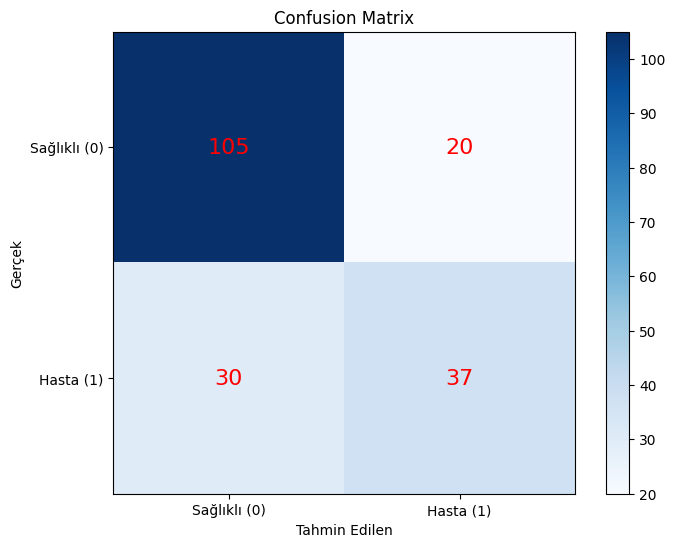

In [11]:
# Karışıklık matrisi
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.xticks([0, 1], ['Sağlıklı (0)', 'Hasta (1)'])
plt.yticks([0, 1], ['Sağlıklı (0)', 'Hasta (1)'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red', fontsize=16)

plt.colorbar()
plt.show()

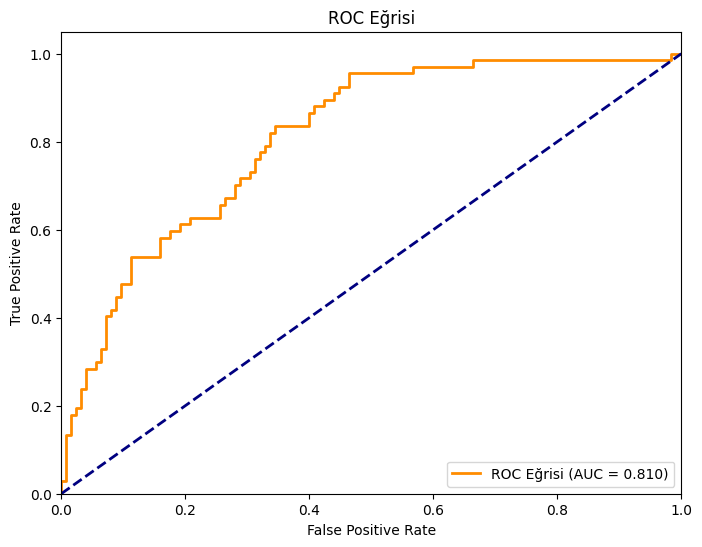

In [12]:
# ROC Eğrisi
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Eğrisi (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

Bu kod parçası, modelin başarısını iki önemli metrikle görselleştirmektedir: **Karışıklık Matrisi (Confusion Matrix)** ve **ROC Eğrisi**. Her iki metrik de modelin doğruluğunu ve başarısını değerlendirmede önemli rol oynar. Adım adım açıklayalım:

### 1. **Karışıklık Matrisi (Confusion Matrix):**
```python
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.xticks([0, 1], ['Sağlıklı (0)', 'Hasta (1)'])
plt.yticks([0, 1], ['Sağlıklı (0)', 'Hasta (1)'])
```
- **`confusion_matrix(y_test, y_pred)`**: Bu fonksiyon, modelin test seti üzerindeki tahminlerini ve gerçek etiketlerini karşılaştırarak **karışıklık matrisini** oluşturur. Bu matris, dört ana bölüme ayrılır:
  - **True Positives (TP)**: Model doğru bir şekilde pozitif (hasta) sınıfını tahmin ettiğinde.
  - **True Negatives (TN)**: Model doğru bir şekilde negatif (sağlıklı) sınıfını tahmin ettiğinde.
  - **False Positives (FP)**: Model yanlış bir şekilde negatif sınıfı pozitif olarak tahmin ettiğinde.
  - **False Negatives (FN)**: Model yanlış bir şekilde pozitif sınıfı negatif olarak tahmin ettiğinde.

- **`plt.imshow(cm, cmap='Blues')`**: Bu satır, karışıklık matrisini görselleştirir ve renk paleti olarak mavi tonlarını kullanır.
  
- **`plt.xticks([0, 1], ['Sağlıklı (0)', 'Hasta (1)'])`** ve **`plt.yticks([0, 1], ['Sağlıklı (0)', 'Hasta (1)'])`**: Bu satırlar, x ve y eksenlerinde hangi sınıfların temsil edildiğini belirtir. Yani, x ekseni "Tahmin Edilen" sınıfı, y ekseni ise "Gerçek" sınıfı için etiketler ekler.
  
- **`for i in range(2): for j in range(2): plt.text(j, i, cm[i, j], ha='center', va='center', color='red', fontsize=16)`**: Bu döngü, karışıklık matrisinin her hücresine **değer** ekler ve bu değeri **kırmızı** renkte gösterir. Bu sayede karışıklık matrisinin içeriği görsel olarak da anlaşılır hale gelir.

- **`plt.colorbar()`**: Bu, renk paletinin sağ tarafında bir renk çubuğu ekler, böylece renklerin hangi değerleri temsil ettiğini kullanıcıya gösterir.

### 2. **ROC Eğrisi (Receiver Operating Characteristic Curve):**
```python
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Eğrisi (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()
```
- **`roc_curve(y_test, y_pred_proba)`**: Bu fonksiyon, **ROC eğrisini** oluşturmak için kullanılan **False Positive Rate (FPR)** ve **True Positive Rate (TPR)** değerlerini hesaplar. Bu metrikler aşağıdaki gibi tanımlanır:
  - **False Positive Rate (FPR)**: Yanlış pozitiflerin (modelin yanlışlıkla pozitif tahmin ettiği örneklerin) oranıdır. 
  - **True Positive Rate (TPR)**: Gerçek pozitiflerin (modelin doğru bir şekilde pozitif tahmin ettiği örneklerin) oranıdır.

- **`roc_auc = auc(fpr, tpr)`**: Bu satır, **AUC (Area Under the Curve)** değerini hesaplar. AUC, ROC eğrisinin altında kalan alanı temsil eder. AUC değeri ne kadar yüksekse, modelin doğruluğu o kadar iyidir. AUC değeri 1'e yakınsa, model mükemmel performans gösterir, 0.5'e yakınsa model rastgele tahmin yapıyordur.

- **`plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Eğrisi (AUC = {roc_auc:.3f})')`**: ROC eğrisini çizen bir satır ekler. Eğriyi çizmek için **False Positive Rate (fpr)** ve **True Positive Rate (tpr)** değerleri kullanılır ve eğri **turuncu** renkte gösterilir. AUC değeri de grafikte gösterilir.

- **`plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')`**: Bu, **rastgele tahmin yapan bir modelin** ROC eğrisini gösteren bir çizgidir. Bu çizgi, modelin sıfır performansını temsil eder.

- **`plt.xlim([0.0, 1.0])`** ve **`plt.ylim([0.0, 1.05])`**: Bu, ROC eğrisinin eksen sınırlarını belirler. X ekseni **False Positive Rate**, Y ekseni ise **True Positive Rate**'i temsil eder.

- **`plt.legend(loc="lower right")`**: Bu, ROC eğrisine dair açıklamayı (AUC değeriyle birlikte) **grafiğin sağ alt köşesine** yerleştirir.

### Özet:
- **Karışıklık Matrisi**: Modelin her sınıf için yaptığı doğru ve yanlış tahminlerin sayısını görselleştirir. Bu, modelin performansını daha ayrıntılı şekilde değerlendirmenizi sağlar.
- **ROC Eğrisi ve AUC**: Modelin **pozitif sınıf** üzerinde nasıl performans gösterdiğini gösteren bir görselleştirmedir. **AUC değeri**, modelin sınıflandırma yeteneğini ölçen bir metrik olup, 1'e yakın değerler iyi bir modeli gösterir.

Her iki görselleştirme, modelin sınıflandırma görevinde ne kadar iyi performans gösterdiğini anlamanızı sağlar.

In [13]:
# Öznitelik önemlerini görselleştir (Random Forest ile)
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

Bu satırda, **Random Forest** modelinin eğitildiği ve özelliklerin (özniteliklerin) önem derecelerinin hesaplandığı bir işlem yapılmaktadır. Şimdi adım adım açıklayalım:

### 1. **RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')**
- **`RandomForestClassifier`**: Bu, **Random Forest** algoritmasını kullanan bir sınıflandırıcıdır. Random Forest, çok sayıda karar ağacını bir araya getirerek güçlü bir topluluk modeline (ensemble model) dönüşür. Her bir karar ağacı, farklı bir veri alt kümesi üzerinde eğitilir ve nihai tahmin, tüm ağaçlardan alınan tahminlerin çoğunluk oyuyla belirlenir.
  
  - **`n_estimators=300`**: Random Forest modelinin kaç adet karar ağacı kullanacağını belirtir. Bu örnekte, model 300 farklı karar ağacından oluşacak. Genellikle daha fazla ağaç kullanmak modelin genelleme kapasitesini artırabilir.
  
  - **`random_state=42`**: Bu parametre, modelin sonuçlarını tekrar edilebilir yapmak için kullanılır. Yani aynı veri ve aynı parametrelerle, bu kod her çalıştırıldığında aynı sonuçları elde edersiniz. Bu özellikle deneylerinizi tutarlı hale getirmek için önemlidir. Buradaki `42` sadece bir sayıdır, farklı bir sayı da seçilebilir, ancak sayı sabit tutulursa sonuçlar tekrarlanabilir olur.
  
  - **`class_weight='balanced'`**: Bu parametre, sınıflar arasındaki dengesizliği ele almak için kullanılır. Eğer sınıflar arasında ciddi bir dengesizlik varsa (örneğin, pozitif sınıf çok az örneğe sahipse), bu parametre sınıf ağırlıklarını otomatik olarak ayarlayarak modelin daha iyi öğrenmesini sağlar. `'balanced'` değeri, her sınıfa ağırlık vererek sınıflar arasındaki dengesizliği dengelemeye çalışır.

### 2. **rf_model.fit(X_train_scaled, y_train)**
- **`fit()`**: Bu metod, verilen eğitim verisi üzerinde modelin öğrenmesini sağlar. 
  - **`X_train_scaled`**: Bu, eğitim verisinin **özellikler**dir. Burada özellikler (feature'lar) zaten standartlaştırılmış, yani her özelliğin ortalaması 0 ve standart sapması 1 olacak şekilde dönüştürülmüştür.
  - **`y_train`**: Bu, eğitim verisinin **etiketleri**dir. Modelin öğrenmeye çalıştığı doğru sınıf etiketleri.

### Sonuç:
Bu satırda, **Random Forest** sınıflandırıcı modeli **300 adet karar ağacı ile eğitilmektedir**. Model, eğitim verisindeki özellikleri ve etiketleri kullanarak öğrenir. Ayrıca, **sınıf dengesizliğini** ele almak amacıyla **`class_weight='balanced'`** parametresi kullanılır.

Model eğitildikten sonra, **özelliklerin önem derecelerini** incelemek için `rf_model.feature_importances_` özelliği kullanılabilir. Bu özellik, her bir özelliğin (özelliklerin) modelin karar verme sürecindeki ne kadar önemli olduğunu belirler. Özelliklerin önem derecelerini görselleştirmek, hangi özelliklerin modelin doğru tahminler yapmasına daha fazla katkı sağladığını anlamanızı sağlar.

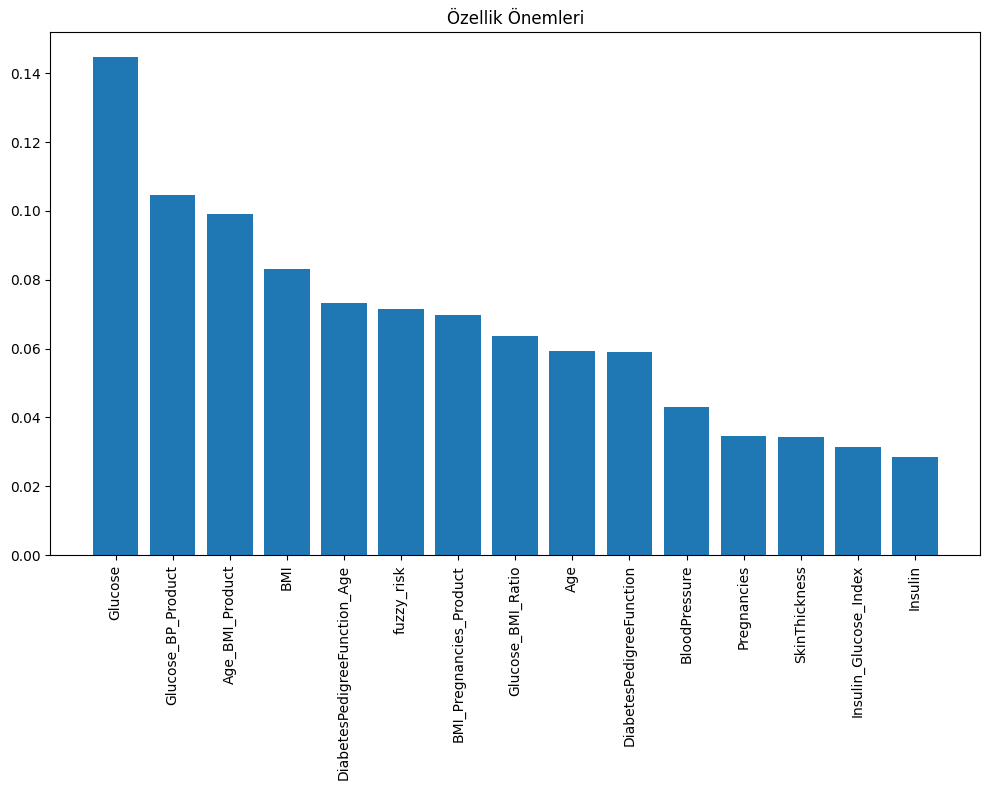

In [14]:
# Özellik önemlerini görselleştir
plt.figure(figsize=(10, 8))
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Özellik Önemleri')
plt.bar(range(X_train_scaled.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train_scaled.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

Bu kod, **Random Forest** modelinin **özellik önemlerini** görselleştirmek için kullanılır. Özelliklerin modeldeki katkılarını anlamak, hangi özelliklerin modelin tahminlerine daha fazla etki ettiğini görmek için önemlidir. Şimdi her adımı açıklayalım:

### 1. **`plt.figure(figsize=(10, 8))`**
- Bu satır, grafik boyutlarını belirler. `figsize=(10, 8)` parametresi ile grafik 10 birim genişliğinde ve 8 birim yüksekliğinde olacak şekilde ayarlanır. Bu, grafiğin rahatça görsel olarak incelenebilmesi için önemlidir.

### 2. **`importances = rf_model.feature_importances_`**
- Bu satır, **Random Forest modelinden** her bir özelliğin (özelliğin) modelin tahminlerine olan önem derecelerini alır. 
  - **`feature_importances_`**: Bu özellik, modelin her bir özelliğin (özelliklerin) tahminlerine ne kadar katkı sağladığını gösteren bir dizidir. Yüksek bir değer, o özelliğin model için daha önemli olduğunu gösterir.

### 3. **`indices = np.argsort(importances)[::-1]`**
- **`np.argsort(importances)`**: Bu fonksiyon, özelliklerin önem derecelerine göre sıralanmış indekslerin dizisini döndürür. Örneğin, en yüksek öneme sahip özelliğin indeksi ilk sırada olacaktır.
- **`[::-1]`**: Bu dilimleme (slicing) işlemi, sıralı diziyi tersten alır, yani en önemli özelliği ilk sıraya yerleştirir. Bu, önem derecelerinin azalan sırayla sıralanmasını sağlar.

### 4. **`plt.title('Özellik Önemleri')`**
- Bu satır, görselin başlığını ayarlar. Grafiğin başlığı **"Özellik Önemleri"** olarak belirlenmiş, bu da grafiğin neyi gösterdiğini belirtir.

### 5. **`plt.bar(range(X_train_scaled.shape[1]), importances[indices], align='center')`**
- **`plt.bar()`**: Bu fonksiyon, çubuk grafik çizer.
  - **`range(X_train_scaled.shape[1])`**: Bu, grafikte gösterilecek olan çubukların x-ekseni değerlerini oluşturur. Burada, `X_train_scaled.shape[1]`, eğitim verisindeki özellik sayısını ifade eder, yani kaç tane özellik olduğunu belirtir.
  - **`importances[indices]`**: Bu, özelliklerin sıralı önem derecelerini kullanarak her bir özelliğin önemini gösterir.
  - **`align='center'`**: Bu parametre, çubukların eksen üzerinde hizalanmasını sağlar.

### 6. **`plt.xticks(range(X_train_scaled.shape[1]), [feature_names[i] for i in indices], rotation=90)`**
- Bu satır, x-ekseni üzerindeki etiketleri (özellik isimlerini) ayarlar.
  - **`range(X_train_scaled.shape[1])`**: x-ekseni etiketlerinin sayısını belirtir.
  - **`[feature_names[i] for i in indices]`**: Bu, özellik isimlerini sıralı şekilde alır. `indices` dizisi, sıralı özelliklerin indekslerini içerdiği için bu liste, en önemli özelliği ilk sıraya alacak şekilde sıralanır.
  - **`rotation=90`**: Etiketlerin dikey olarak döndürülmesini sağlar. Bu, uzun etiketlerin daha rahat okunabilmesi için kullanılır.

### 7. **`plt.tight_layout()`**
- Bu fonksiyon, grafik öğelerinin yerleşimini daha düzenli hale getirir. Grafik elemanları (başlık, etiketler, eksenler) sıkışmasın ve her şey rahatça görünür olsun diye bu fonksiyon kullanılır.

### 8. **`plt.show()`**
- Bu, oluşturulan grafiği ekranda gösterir. Yani bu kodu çalıştırdığınızda, grafik ekranda belirecek ve özelliklerin önem derecelerini görsel olarak inceleyebilirsiniz.

### Sonuç:
Bu grafik, **Random Forest** modelinin her bir özelliğin tahminlere katkısını **çubuk grafik** olarak görselleştirir. Çubuklar, her bir özelliğin önem derecesini gösterir, böylece hangi özelliklerin model için daha önemli olduğunu kolayca görebilirsiniz. Özellikler, en önemli olandan en az önemli olana doğru sıralanacaktır. Bu tür bir görselleştirme, modelin karar verme süreçlerini anlamaya ve hangi verilerin daha fazla katkı sağladığını belirlemeye yardımcı olur.

In [15]:
# Tahmin eşiğini optimize ederek performansı artır
# Farklı tahmin eşiklerini dene
thresholds = np.arange(0.3, 0.8, 0.05)
accuracies = []

for threshold in thresholds:
    y_pred_optimized = (y_pred_proba >= threshold).astype(int)
    accuracies.append(accuracy_score(y_test, y_pred_optimized))

# En iyi eşiği bul
best_threshold_idx = np.argmax(accuracies)
best_threshold = thresholds[best_threshold_idx]
best_accuracy = accuracies[best_threshold_idx]

print(f"En iyi eşik: {best_threshold:.2f}, Doğruluk: {best_accuracy:.4f}")

# En iyi eşik ile final tahminleri oluştur
y_pred_best = (y_pred_proba >= best_threshold).astype(int)
print("\nOptimize Edilmiş Eşik ile Sınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred_best))

En iyi eşik: 0.55, Doğruluk: 0.7604

Optimize Edilmiş Eşik ile Sınıflandırma Raporu:

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       125
           1       0.71      0.54      0.61        67

    accuracy                           0.76       192
   macro avg       0.74      0.71      0.72       192
weighted avg       0.75      0.76      0.75       192



Bu kod, **tahmin eşiklerini optimize ederek modelin performansını artırmayı** amaçlamaktadır. Eşik değerinin değiştirilmesi, modelin doğruluk, duyarlılık, özgüllük gibi performans metriklerini değiştirebilir. Şimdi adım adım açıklayalım:

### 1. **`thresholds = np.arange(0.3, 0.8, 0.05)`**
- Bu satır, farklı **eşik (threshold)** değerlerini oluşturur. 
  - **`np.arange(0.3, 0.8, 0.05)`** fonksiyonu, 0.3'ten başlayarak 0.8'e kadar 0.05 artışlarla bir dizi oluşturur. Yani, `thresholds = [0.3, 0.35, 0.4, 0.45, ..., 0.75]` şeklinde bir dizi elde edilir.
  - Bu eşik değerleri, tahminlerin doğru sınıfa atanmasında kullanılacak sınırları belirler.

### 2. **`accuracies = []`**
- Bu satır, her bir eşik değeri için hesaplanacak **doğruluk (accuracy)** skorlarını saklamak için boş bir liste oluşturur.

### 3. **`for threshold in thresholds:`**
- Bu döngü, her bir eşik değeri için tahmin yapacak ve doğruluğu hesaplayacaktır.

### 4. **`y_pred_optimized = (y_pred_proba >= threshold).astype(int)`**
- **`y_pred_proba`**: Bu, modelin her bir örnek için her sınıfa ait tahmin edilen olasılıkları içerir. Genellikle, bu olasılık **1. sınıf** için verilir (örneğin, hasta olan sınıf için).
- **`(y_pred_proba >= threshold)`**: Bu, her tahminin, eşik değeriyle karşılaştırılmasını sağlar. Eğer tahmin edilen olasılık belirtilen eşikten büyük veya eşitse, sonuç **1** (hasta) olarak kabul edilir; aksi takdirde **0** (sağlıklı) olarak kabul edilir.
  - Örneğin, eğer eşik 0.5 ise ve tahmin edilen olasılık 0.6 ise, **1** (hasta) olacak şekilde tahmin edilir.
- **`.astype(int)`**: Bu, boole (True/False) değerlerini 0 ve 1'e dönüştürür.
  
### 5. **`accuracies.append(accuracy_score(y_test, y_pred_optimized))`**
- Bu satır, her bir eşik için elde edilen **doğruluk skorunu** hesaplar ve `accuracies` listesine ekler.
  - **`accuracy_score(y_test, y_pred_optimized)`**: Gerçek etiketler (`y_test`) ile optimize edilmiş tahminler (`y_pred_optimized`) arasındaki doğruluğu hesaplar.

### 6. **`best_threshold_idx = np.argmax(accuracies)`**
- Bu satır, **en yüksek doğruluğa sahip eşik değerini** bulur.
  - **`np.argmax(accuracies)`**: Bu fonksiyon, doğrulukların bulunduğu dizide en yüksek değeri bulan indeksin konumunu döndürür.

### 7. **`best_threshold = thresholds[best_threshold_idx]`**
- **`best_threshold`**: En yüksek doğruluğu veren eşik değerini alır.

### 8. **`best_accuracy = accuracies[best_threshold_idx]`**
- **`best_accuracy`**: En yüksek doğruluk değerini saklar.

### 9. **`print(f"En iyi eşik: {best_threshold:.2f}, Doğruluk: {best_accuracy:.4f}")`**
- Bu satır, en iyi eşik değerini ve bu eşikle elde edilen doğruluğu ekrana yazdırır.

### 10. **`y_pred_best = (y_pred_proba >= best_threshold).astype(int)`**
- Bu satır, **en iyi eşik değeri ile tahmin yapar** ve optimize edilmiş tahminleri (`y_pred_best`) elde eder. Yani, `best_threshold` değeri ile tüm test verisini yeniden sınıflandırır.

### 11. **`print("\nOptimize Edilmiş Eşik ile Sınıflandırma Raporu:\n")`**
- Bu satır, ekrana optimize edilmiş eşik ile yapılan sınıflandırma raporunun başlığını yazdırır.

### 12. **`print(classification_report(y_test, y_pred_best))`**
- Bu satır, **optimize edilmiş eşik ile elde edilen modelin performansını değerlendirir**.
  - **`classification_report(y_test, y_pred_best)`**: Bu fonksiyon, doğruluk, duyarlılık (recall), özgüllük (specificity), F1 skoru gibi metrikleri içeren ayrıntılı bir sınıflandırma raporu sağlar.

### Özet:
- Bu kod, farklı eşik değerleri kullanarak **optimize edilmiş tahminler** elde etmeyi amaçlar. Farklı eşiklerle doğruluğu değerlendirir ve en iyi performans gösteren eşik değerini seçer.
- Ardından, bu en iyi eşik ile final tahminlerini yapar ve modelin sınıflandırma performansını daha detaylı bir şekilde gösteren bir rapor sunar.



Örnek Vaka Analizi (Index: 0):
Glukoz: 104.0
BMI: 31.2
Yaş: 38.0
Kan Basıncı: 72.0
Pedigree Fonksiyonu: 0.465
Bulanık Risk Skoru: 50.0
Gerçek Etiket: Hasta
Tahmin Edilen Etiket: Sağlıklı
Diyabet Olasılığı: 0.386


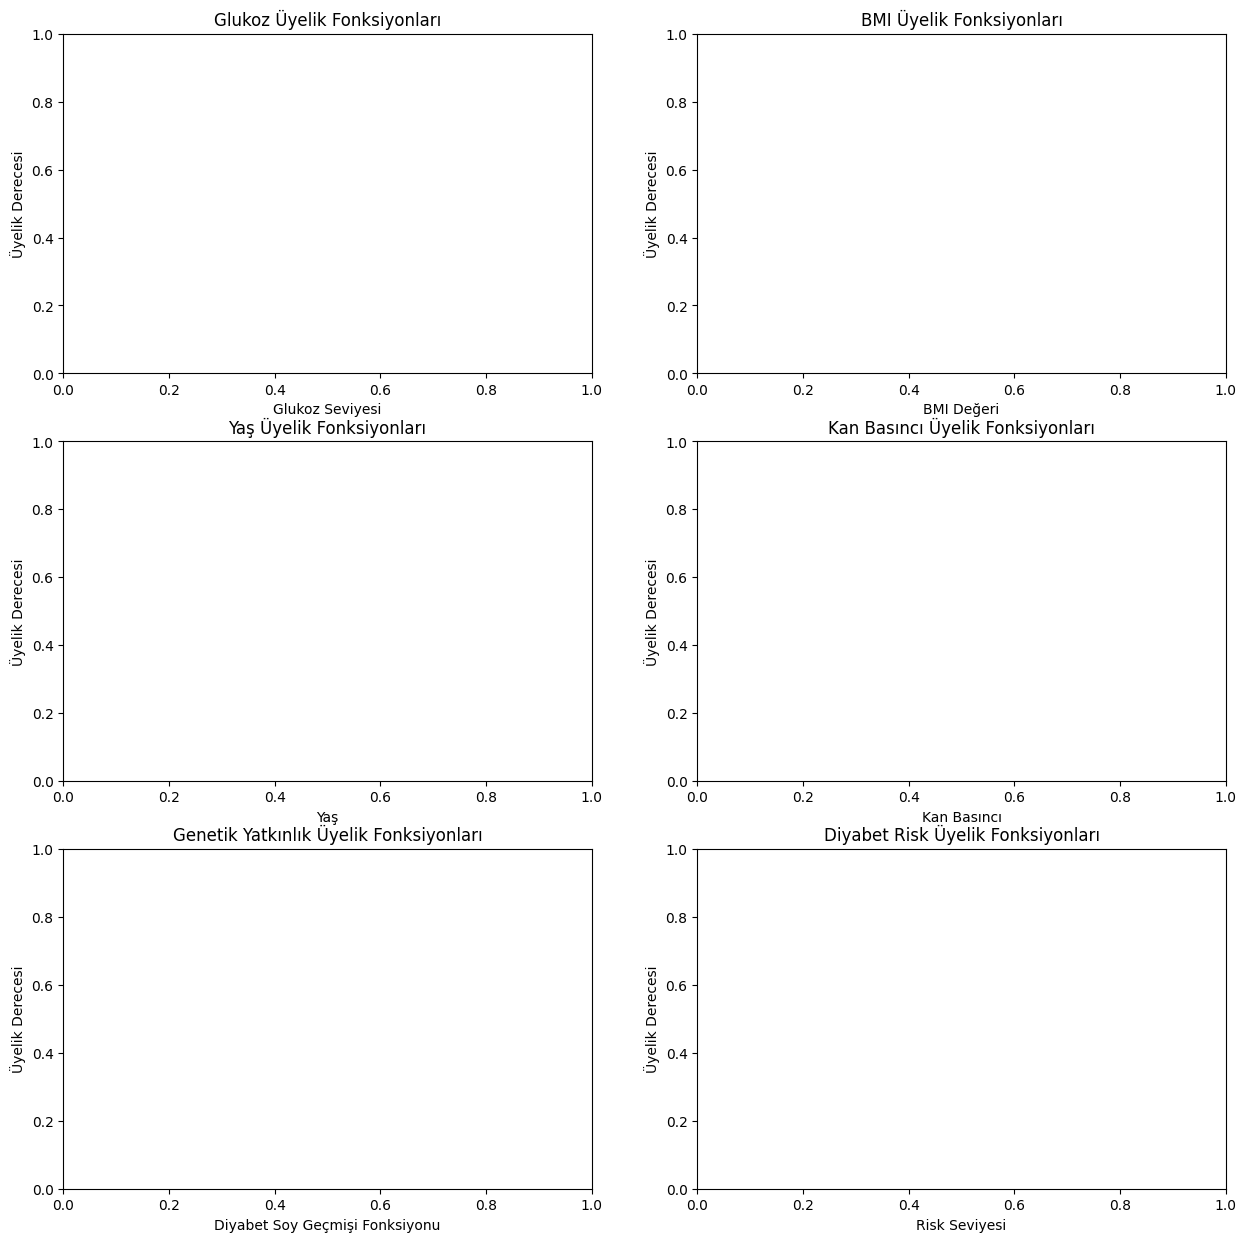

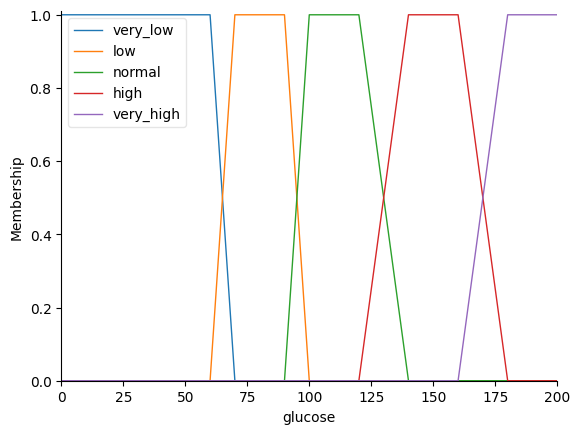

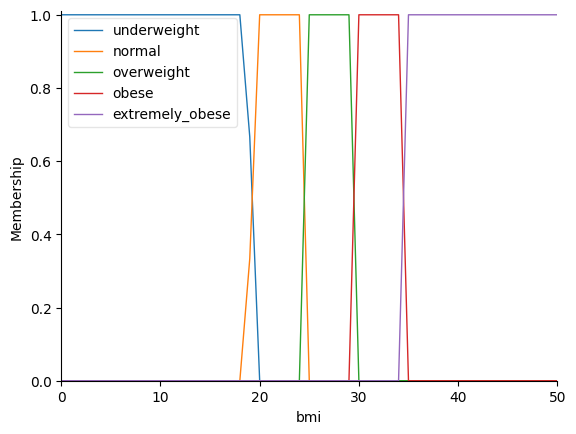

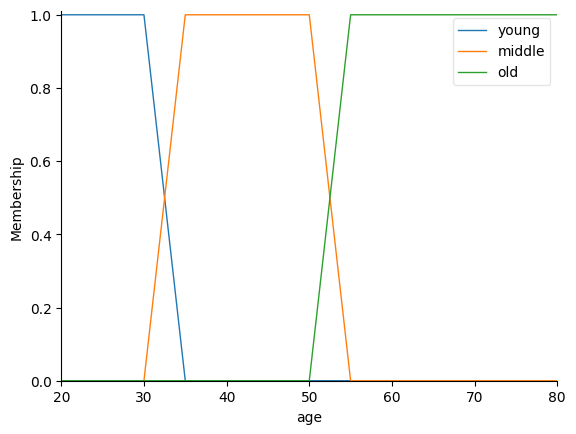

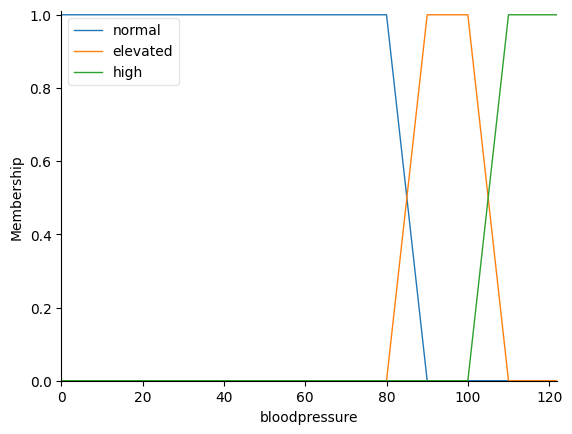

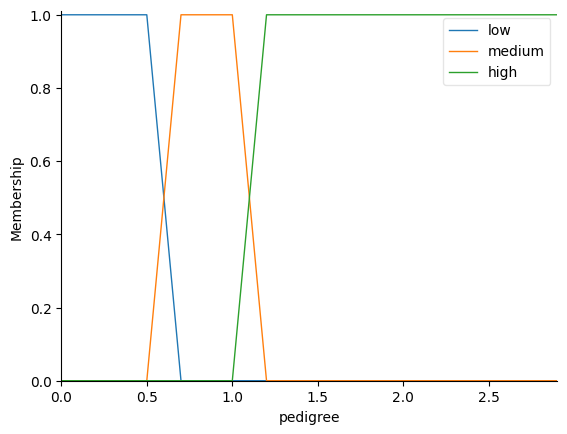

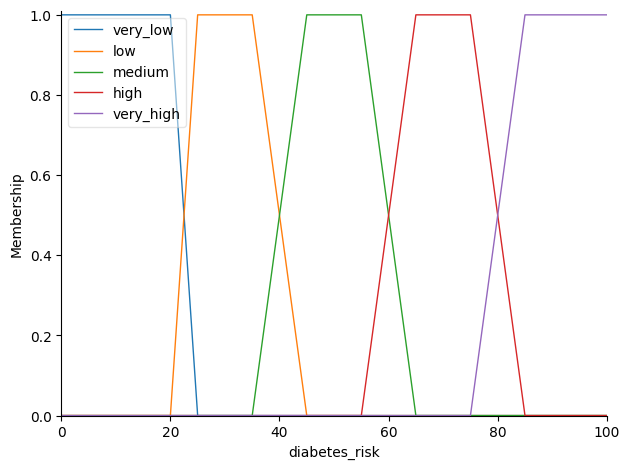

In [16]:
# Önemli özellikleri görselleştir
# Örnek bir vakanın risk değerlendirmesi
example_idx = 0  # İlk test örneği
example_data = X_test.iloc[example_idx]
example_risk = fuzzy_risks_test[example_idx][0]
example_true_label = y_test.iloc[example_idx]
example_pred_label = y_pred[example_idx]

print(f"\nÖrnek Vaka Analizi (Index: {example_idx}):")
print(f"Glukoz: {example_data['Glucose']:.1f}")
print(f"BMI: {example_data['BMI']:.1f}")
print(f"Yaş: {example_data['Age']:.1f}")
print(f"Kan Basıncı: {example_data['BloodPressure']:.1f}")
print(f"Pedigree Fonksiyonu: {example_data['DiabetesPedigreeFunction']:.3f}")
print(f"Bulanık Risk Skoru: {example_risk:.1f}")
print(f"Gerçek Etiket: {'Hasta' if example_true_label == 1 else 'Sağlıklı'}")
print(f"Tahmin Edilen Etiket: {'Hasta' if example_pred_label == 1 else 'Sağlıklı'}")
print(f"Diyabet Olasılığı: {y_pred_proba[example_idx]:.3f}")

# Fuzzy sistemin üyelik fonksiyonlarını görselleştir
rules, glucose, bmi, age, bloodpressure, pedigree, diabetes_risk = create_fuzzy_system()

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# 1. grafik
glucose.view(ax=axes[0, 0])
axes[0, 0].set_title('Glukoz Üyelik Fonksiyonları')
axes[0, 0].set_xlabel('Glukoz Seviyesi')
axes[0, 0].set_ylabel('Üyelik Derecesi')

# 2. grafik
bmi.view(ax=axes[0, 1])
axes[0, 1].set_title('BMI Üyelik Fonksiyonları')
axes[0, 1].set_xlabel('BMI Değeri')
axes[0, 1].set_ylabel('Üyelik Derecesi')

# 3. grafik
age.view(ax=axes[1, 0])
axes[1, 0].set_title('Yaş Üyelik Fonksiyonları')
axes[1, 0].set_xlabel('Yaş')
axes[1, 0].set_ylabel('Üyelik Derecesi')

# 4. grafik
bloodpressure.view(ax=axes[1, 1])
axes[1, 1].set_title('Kan Basıncı Üyelik Fonksiyonları')
axes[1, 1].set_xlabel('Kan Basıncı')
axes[1, 1].set_ylabel('Üyelik Derecesi')

# 5. grafik
pedigree.view(ax=axes[2, 0])
axes[2, 0].set_title('Genetik Yatkınlık Üyelik Fonksiyonları')
axes[2, 0].set_xlabel('Diyabet Soy Geçmişi Fonksiyonu')
axes[2, 0].set_ylabel('Üyelik Derecesi')

# 6. grafik
diabetes_risk.view(ax=axes[2, 1])
axes[2, 1].set_title('Diyabet Risk Üyelik Fonksiyonları')
axes[2, 1].set_xlabel('Risk Seviyesi')
axes[2, 1].set_ylabel('Üyelik Derecesi')

plt.tight_layout()
plt.show()

Bu kod, **özelliklerin önemini görselleştirmek**, **bir örnek vakayı analiz etmek** ve **bulanık sistemin üyelik fonksiyonlarını** görselleştirmek amacıyla yazılmıştır. Şimdi her bir bölümü açıklayalım:

### 1. **Örnek Vaka Analizi:**
Bu bölüm, test veri setinden bir örnek vakayı seçerek **özelliklerini** ve **model tahminlerini** analiz etmektedir.

- **`example_idx = 0`**: Bu, ilk test örneğini seçmek için kullanılan bir indeks değeri. `example_idx = 0` demek, ilk örneği incelemek anlamına gelir.
- **`example_data = X_test.iloc[example_idx]`**: Test verisindeki bu örneğin özellikleri (`Glucose`, `BMI`, `Age`, `BloodPressure`, `DiabetesPedigreeFunction`) seçilir.
- **`example_risk = fuzzy_risks_test[example_idx][0]`**: Bu satırda, seçilen örneğin **bulanık risk skoru** alınır.
- **`example_true_label = y_test.iloc[example_idx]`**: Gerçek etiket alınır (yani, bu kişinin sağlıklı mı hasta mı olduğu).
- **`example_pred_label = y_pred[example_idx]`**: Modelin tahmin ettiği etiket alınır (modelin bu kişiyi sağlıklı ya da hasta olarak sınıflandırdığı sonuç).
- **`print()` komutları**: Bu satırlar, seçilen örneğe ait bilgileri ekrana yazdırır, böylece modelin kararlarını daha iyi anlayabilirsiniz:
  - Glukoz seviyesi, BMI, yaş, kan basıncı, genetik yatkınlık, bulanık risk skoru gibi bilgileri yazdırır.
  - Ayrıca, gerçek etiket ile modelin tahmin ettiği etiket karşılaştırılır.

### 2. **Bulanık Sistemin Üyelik Fonksiyonları:**
Bu bölümde, oluşturduğunuz **bulanık kontrol sistemi** için **üyelik fonksiyonları** görselleştirilir. Bu, sistemin her bir özelliğe nasıl tepki verdiğini anlamanıza yardımcı olur. Bu fonksiyonlar, **fuzzy logic** kullanarak karar verme sürecinde her bir özelliğin ne kadar güçlü bir şekilde katıldığını gösterir.

- **`create_fuzzy_system()`**: Bu fonksiyon, **bulanık sistemin kurallarını** ve üyelik fonksiyonlarını oluşturur. Bu fonksiyonun daha önce tanımlandığını varsayıyoruz.
  
  Fonksiyonda:
  - **`glucose`, `bmi`, `age`, `bloodpressure`, `pedigree`, `diabetes_risk`**: Bunlar, bulanık sisteme ait **üyelik fonksiyonlarıdır**. Bu fonksiyonlar, her özelliğin belirli bir aralıktaki değerine karşılık gelen üyelik derecelerini gösterir.
  
- **`fig, axes = plt.subplots(3, 2, figsize=(15, 15))`**: Bu satır, altı farklı grafik için bir figür ve eksenler oluşturur. Bu sayede, her bir özellik için bir grafik oluşturulacak.
  - 3 satır ve 2 sütundan oluşan bir grid (3x2) yapısı oluşturulur.
  
- **Üyelik Fonksiyonlarının Görselleştirilmesi:**
  - **`glucose.view(ax=axes[0, 0])`**: Glukoz özelliği için üyelik fonksiyonunu **ilk grafikte** görselleştirir. Burada `view()` fonksiyonu, `glucose`'un **üyelik fonksiyonlarını çizmek** için kullanılır. Benzer şekilde, diğer üyelik fonksiyonları da aynı şekilde çizilir.
  - Her bir grafiğin başlıkları (`set_title`) ve etiketleri (`set_xlabel`, `set_ylabel`) atanır.
  
- **`plt.tight_layout()`**: Bu satır, görselleştirilen grafiklerin düzenini düzgün tutmak için kullanılır. Grafikler arasındaki boşlukları otomatik olarak ayarlayarak daha düzenli bir görünüm sağlar.
- **`plt.show()`**: Son olarak, tüm görselleştirmeleri ekrana getirir.

### Sonuç:
- **Örnek vaka analizi** ile, seçilen bir örnek üzerinden tüm **özelliklerin** ve modelin **tahminlerinin** nasıl bir ilişki içinde olduğunu görebilirsiniz. Bu, modelin kararları hakkında daha fazla bilgi edinmenizi sağlar.
- **Üyelik fonksiyonları** görselleştirilerek, her bir özelliğin **bulanık sistemdeki etkisi** ve **katılımı** daha açık bir şekilde gösterilir. Bu, fuzzy logic ile çalışmanın temel bir parçasıdır çünkü her özellik, belirli bir risk seviyesine nasıl katkı sağladığını farklı derecelerde ifade eder.

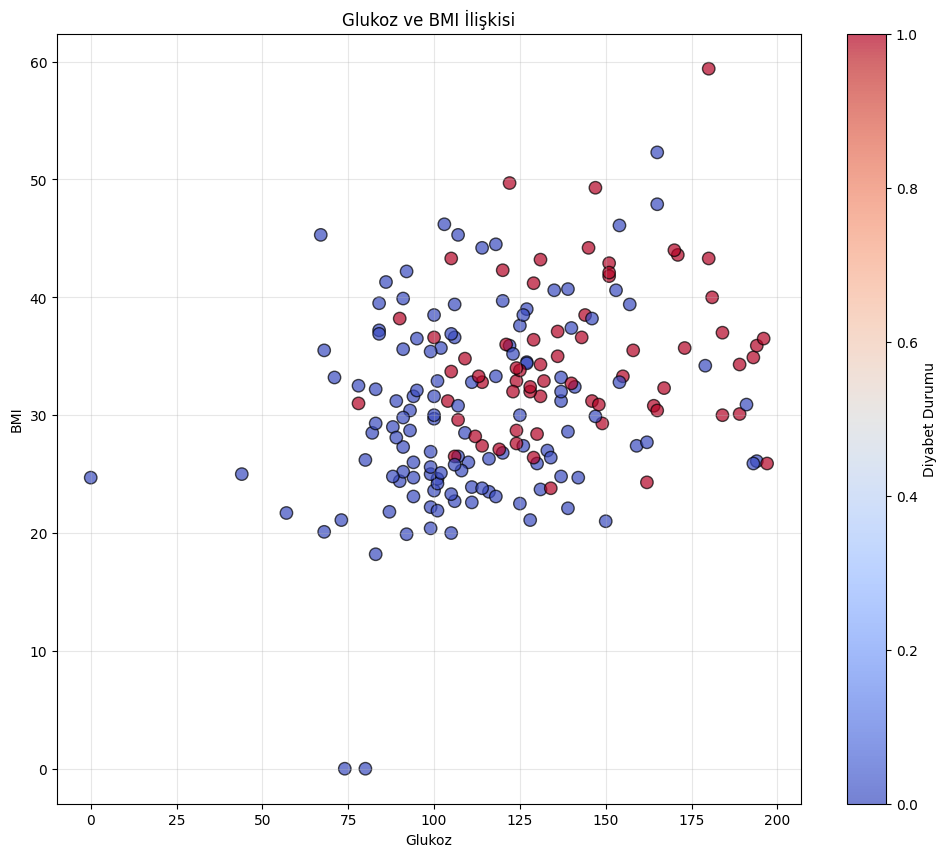

In [ ]:
# Özellik çiftlerinin ilişkisini görselleştir (renkler gerçek sınıfı gösterir)
plt.figure(figsize=(12, 10))
plt.scatter(X_test['Glucose'], X_test['BMI'], c=y_test, cmap='coolwarm', 
            edgecolor='k', s=80, alpha=0.7)
plt.colorbar(label='Diyabet Durumu')
plt.title('Glukoz ve BMI İlişkisi')
plt.xlabel('Glukoz')
plt.ylabel('BMI')
plt.grid(True, alpha=0.3)
plt.show()

Bu kod, **iki özellik arasındaki ilişkiyi görselleştiren** bir **scatter plot (dağılım grafiği)** oluşturur. Bu grafik, `Glucose` (Glukoz) ve `BMI` (Body Mass Index - Vücut Kitle İndeksi) özelliklerinin birbirleriyle olan ilişkisini ve aynı zamanda **gerçek sınıf** bilgisini renklerle göstermek için kullanılır. Aşağıda her bir satırın işlevi açıklanmıştır:

### 1. **Grafiğin Yapısı:**
```python
plt.figure(figsize=(12, 10))
```
- Bu satır, grafiğin boyutlarını belirler. **12x10 inç** boyutlarında bir görselleştirme yapılacak.

### 2. **Dağılım Grafiği:**
```python
plt.scatter(X_test['Glucose'], X_test['BMI'], c=y_test, cmap='coolwarm', 
            edgecolor='k', s=80, alpha=0.7)
```
- **`X_test['Glucose']` ve `X_test['BMI']`**: `X_test` veri setindeki **Glukoz** ve **BMI** değerleri kullanılarak her bir nokta için **x ve y eksenindeki konumlar** belirlenir.
- **`c=y_test`**: Noktaların renkleri, **gerçek sınıf etiketine** (yani, **diyabet durumu**) göre ayarlanır. **0** (sağlıklı) ve **1** (hasta) etiketlerine göre renkler atanır.
- **`cmap='coolwarm'`**: **Renk paleti** belirlenir. Burada 'coolwarm' paleti kullanılır, bu da genellikle soğuk renkleri (mavi) sağlıklı (0) etiketine ve sıcak renkleri (kırmızı) hasta (1) etiketine atar.
- **`edgecolor='k'`**: Her bir noktanın etrafına **siyah** (`k` = black) renkli bir sınır ekler. Bu, noktaların daha belirgin görünmesini sağlar.
- **`s=80`**: Noktaların boyutunu 80 olarak ayarlar, yani daha büyük noktalar görselleştirilecektir.
- **`alpha=0.7`**: Noktaların **şeffaflık seviyesini** ayarlar. 0.7 şeffaflık değeri, noktaların daha az opak olmasını sağlar, yani arka plandaki noktalar biraz daha görünür olur.

### 3. **Renkli Dereceleme:**
```python
plt.colorbar(label='Diyabet Durumu')
```
- Bu satır, renk skalasının yanında bir **renk barı (color bar)** ekler. Renk barı, diyabet durumu etiketini (0 = sağlıklı, 1 = hasta) renklerle ilişkilendirir. Etiketin yanında görünen renkler, her noktadaki diyabet durumunu temsil eder.

### 4. **Grafik Başlığı ve Etiketler:**
```python
plt.title('Glukoz ve BMI İlişkisi')
plt.xlabel('Glukoz')
plt.ylabel('BMI')
```
- **`plt.title()`**: Grafik için başlık belirler. Bu başlıkta, grafiğin **Glukoz ve BMI arasındaki ilişkiyi** gösterdiği belirtilir.
- **`plt.xlabel()` ve `plt.ylabel()`**: Grafik eksenlerine etiketler ekler. **X ekseni** için **Glukoz**, **Y ekseni** için ise **BMI** yazılır.

### 5. **Grid ve Görselleştirme:**
```python
plt.grid(True, alpha=0.3)
plt.show()
```
- **`plt.grid(True, alpha=0.3)`**: Grafikte **ızgara (grid)** çizgilerinin görünür olmasını sağlar. **`alpha=0.3`** ile çizgiler daha az belirgin yapılır (şeffaflık eklenir).
- **`plt.show()`**: Grafiği ekranda gösterir.

### Sonuç:
Bu grafik, **Glukoz** ve **BMI** arasındaki ilişkiyi gösteren bir dağılım grafiği sunar. Grafik üzerinde, **diyabet durumu** (sağlıklı/hasta) renklerle gösterilmektedir. Sağlıklı bireyler **mavi** renkte, hasta bireyler ise **kırmızı** renkte görselleştirilir. Bu görselleştirme, bu iki özelliğin (Glukoz ve BMI) diyabet durumu ile olan ilişkisini görsel olarak keşfetmeye yardımcı olur.

In [18]:
# Tahmin hataları analizi - hangi durumlarda model hata yapıyor?
errors = y_test != y_pred
X_errors = X_test[errors]
y_errors = y_test[errors]

print(f"\nHata Yapılan Örneklerin Analizi (Toplam {np.sum(errors)} hata):")
for feature in ['Glucose', 'BMI', 'Age', 'BloodPressure', 'DiabetesPedigreeFunction']:
    print(f"{feature} - Ortalama: {X_errors[feature].mean():.2f}, Min: {X_errors[feature].min():.2f}, Max: {X_errors[feature].max():.2f}")


Hata Yapılan Örneklerin Analizi (Toplam 50 hata):
Glucose - Ortalama: 132.02, Min: 78.00, Max: 194.00
BMI - Ortalama: 33.79, Min: 23.80, Max: 52.30
Age - Ortalama: 35.20, Min: 21.00, Max: 67.00
BloodPressure - Ortalama: 73.18, Min: 0.00, Max: 106.00
DiabetesPedigreeFunction - Ortalama: 0.42, Min: 0.12, Max: 1.32


Bu kod, **modelin tahmin hatalarını** analiz etmeye yönelik bir inceleme yapar ve modelin hangi durumlarda **hata yaptığını** anlamaya çalışır. Her bir adımın açıklaması aşağıdaki gibidir:

### 1. **Hata Durumlarını Belirleme:**
```python
errors = y_test != y_pred
```
- Bu satırda, **gerçek etiketler (y_test)** ile **modelin tahminleri (y_pred)** karşılaştırılır. **`y_test != y_pred`** ifadesi, her bir örneğin doğru tahmin edilip edilmediğini kontrol eder. 
  - Eğer tahmin doğruysa (yani `y_test == y_pred`), sonuç **`False`** olur.
  - Eğer tahmin yanlışsa (yani `y_test != y_pred`), sonuç **`True`** olur.
- Sonuç olarak **`errors`** adlı bir **boolean dizisi** oluşur. Bu dizi, her bir örnek için modelin **yanlış tahmin yapıp yapmadığını** belirtir.

### 2. **Hatalı Tahminlerle İlgili Verileri Seçme:**
```python
X_errors = X_test[errors]
y_errors = y_test[errors]
```
- **`X_errors = X_test[errors]`**: Bu satır, **hatalı tahmin yapılan örnekleri** seçer. Yani, `errors` dizisinde **`True`** olan yerlerdeki `X_test` verilerini alır. Bu, modelin hata yaptığı **özelliklerin** olduğu bir alt veri seti oluşturur.
- **`y_errors = y_test[errors]`**: Benzer şekilde, **gerçek etiketlerin** hata yapılan örneklerini seçer.

### 3. **Hata Yapılan Örneklerin İstatistiksel Analizi:**
```python
print(f"\nHata Yapılan Örneklerin Analizi (Toplam {np.sum(errors)} hata):")
```
- Bu satırda, toplam **hata yapılan örnek sayısı** (`np.sum(errors)`) yazdırılır. **`np.sum(errors)`** ifadesi, `errors` dizisindeki **`True`** değerlerin sayısını verir (yani modelin yaptığı hatalar).

### 4. **Hatalı Tahminler İçin Özelliklerin İstatistiklerini Hesaplama:**
```python
for feature in ['Glucose', 'BMI', 'Age', 'BloodPressure', 'DiabetesPedigreeFunction']:
    print(f"{feature} - Ortalama: {X_errors[feature].mean():.2f}, Min: {X_errors[feature].min():.2f}, Max: {X_errors[feature].max():.2f}")
```
- Bu döngü, **modelin hata yaptığı örneklerdeki** belirli özelliklerin (özellik listesi: `Glucose`, `BMI`, `Age`, `BloodPressure`, `DiabetesPedigreeFunction`) istatistiklerini hesaplar ve yazdırır.
  - **Ortalama** (`mean()`): Hatalı tahmin yapılan örneklerde, her özelliğin **ortalama değerini** gösterir.
  - **Min** (`min()`): Her özelliğin **minimum** değerini gösterir.
  - **Max** (`max()`): Her özelliğin **maksimum** değerini gösterir.
  
Her bir özellik için **ortalama**, **min** ve **max** değerlerini yazdırarak, hata yapılan örneklerde bu özelliklerin nasıl dağıldığını anlayabilirsiniz. Örneğin:
- Eğer **Glukoz** değeri çok yüksek olan bir örnekte model hata yapıyorsa, bu özellik hakkında daha fazla bilgi edinmek isteyebilirsiniz.
- **BMI** gibi özelliklerin de hata yapılan örneklerde nasıl davrandığını görmek, modelin yanlış sınıflandırdığı verilerdeki özelliklerin ortak bir desenini tespit etmeye yardımcı olabilir.

### Sonuç:
Bu kod parçası, **modelin hangi özelliklerdeki verilerde hata yaptığını** anlamaya yardımcı olur. Hatalı tahmin yapılan örneklerin, her bir özellik için **ortalama**, **min** ve **max** değerlerinin analiz edilmesi, modelin hatalarındaki **potansiyel eğilimleri** keşfetmeye olanak tanır. Bu sayede modelin hangi tür verilerle zorlandığını ve hangi özelliklerin daha dikkatli ele alınması gerektiğini belirlemek mümkündür.

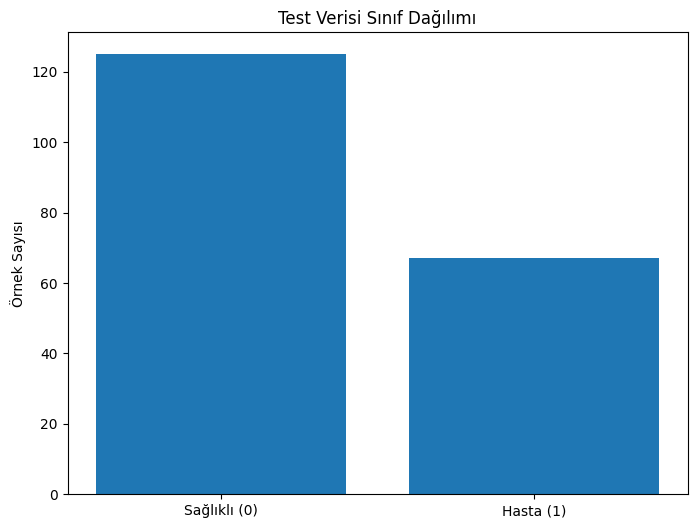

In [19]:
# Sınıflar arası dengesizliği görselleştir
plt.figure(figsize=(8, 6))
plt.bar(['Sağlıklı (0)', 'Hasta (1)'], [np.sum(y_test == 0), np.sum(y_test == 1)])
plt.title('Test Verisi Sınıf Dağılımı')
plt.ylabel('Örnek Sayısı')
plt.show()

In [20]:
# Final model performansı özeti
print("\nFinal Model Performans Özeti:")
print(f"Doğruluk: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Optimum Eşik ile Doğruluk: {best_accuracy:.4f}")


Final Model Performans Özeti:
Doğruluk: 0.7396
ROC AUC: 0.8101
Optimum Eşik ile Doğruluk: 0.7604


### Görselleştirme Açıklaması:
```python
plt.figure(figsize=(8, 6))
plt.bar(['Sağlıklı (0)', 'Hasta (1)'], [np.sum(y_test == 0), np.sum(y_test == 1)])
plt.title('Test Verisi Sınıf Dağılımı')
plt.ylabel('Örnek Sayısı')
plt.show()
```
Bu kod parçası, **test verisindeki sınıf dengesini** görselleştirir. 
- **`np.sum(y_test == 0)`** ve **`np.sum(y_test == 1)`**, test setindeki **sağlıklı** (0) ve **hasta** (1) örneklerinin sayısını hesaplar.
- Ardından, bu sayılar bir çubuk grafiği ile görselleştirilir. Grafikte:
  - **Sağlıklı (0)** ve **Hasta (1)** sınıflarının her birinin **test verisindeki örnek sayısı** gösterilir.
- Bu tür bir görselleştirme, **sınıf dengesizliği** sorununu gözler önüne serer. Eğer bir sınıfın örnek sayısı çok daha fazlaysa (örneğin, sağlıklı sınıfının), modelin sınıf dengesizliğinden etkilenmesi mümkündür. 

### Model Performansı Özeti:
```python
print("\nFinal Model Performans Özeti:")
print(f"Doğruluk: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Optimum Eşik ile Doğruluk: {best_accuracy:.4f}")
```
Bu kod, **final modelin** performansını özetler:
1. **Doğruluk (Accuracy)**: Modelin doğru tahmin oranını gösterir.
   - Yani, test setinde doğru tahmin edilen örneklerin oranı. 
   - **Yüksek doğruluk** genellikle iyi bir performansı gösterse de, **dengesiz sınıflarda** yanıltıcı olabilir. Çünkü model tek bir sınıfa ağırlık verebilir.

2. **ROC AUC**: Bu, modelin **sınıflar arasındaki ayrımı** ne kadar iyi yapabildiğini gösteren bir metriği ifade eder.
   - **ROC (Receiver Operating Characteristic) Eğrisi**, modelin **gerçek pozitif oranı (TPR)** ile **yanlış pozitif oranı (FPR)** arasındaki ilişkiyi görselleştirir.
   - **AUC (Area Under the Curve)** ise ROC eğrisinin altındaki alanı belirtir. Yüksek bir AUC değeri (yaklaşık 1.0), modelin iyi performans gösterdiğini, 0.5'e yakın değerler ise modelin rastgele tahmin yapıyor olduğunu gösterir.
   
3. **Optimum Eşik ile Doğruluk**: Modelin tahmin ettiği olasılıkları bir **eşik değeri (threshold)** ile sınıflara dönüştürür. Bu eşik, modelin ne zaman "1" (hasta) tahmin etmesi gerektiğine karar verir.
   - **Optimum eşik**, doğruluğu en iyi artıran **eşik değeri** olarak belirlenir.
   - **Eşik optimizasyonu** yapmak, modelin doğru sınıflandırma oranını iyileştirebilir ve bu tür ayarlamalar **sınıf dengesizliği** gibi problemlere karşı daha iyi sonuçlar elde etmenize yardımcı olabilir.

### ROC AUC ve Optimum Eşik ile Doğruluk Neden Kullanılır?

1. **ROC AUC**:
   - **ROC AUC**, sınıf dengesizliği durumunda önemli bir metriktir. Eğer sınıflar arasında büyük bir dengesizlik varsa (örneğin, çoğu örnek "sağlıklı" ve çok az "hasta" varsa), sadece doğruluk **yanıltıcı** olabilir. Bu durumda modelin sadece **dominant sınıfı** tahmin etmesi bile yüksek doğruluk sağlar. Ancak bu, modelin aslında iyi performans göstermediği anlamına gelir.
   - **ROC AUC** ise modelin **her iki sınıfı** ayırabilme yeteneğini değerlendirir. Yüksek AUC, modelin her iki sınıfı da doğru şekilde ayırt edebildiğini gösterir.

2. **Optimum Eşik ile Doğruluk**:
   - **Optimum eşik** kullanarak doğruluğu optimize etmek, modelin tahminlerinin **sınıf dağılımını** iyileştirebilir. Örneğin:
     - **0.5 eşik** değerini kullanmak, **0.5'ten büyük** olasılıkla **hasta** sınıfına ve **0.5'ten küçük** olasılıkla **sağlıklı** sınıfına tahmin yapar.
     - Ancak, bu eşik değerini optimize etmek, modelin sınıf dengesizliğinden etkilenmeden daha doğru tahminler yapmasına olanak tanıyabilir.
     - **Optimum eşik** ile doğruluk, modelin **pozitif ve negatif sınıfları** daha iyi dengelemesine ve daha iyi sonuçlar elde etmesine yardımcı olabilir.

### Özetle:
- **ROC AUC** modelin ne kadar iyi ayırım yapabildiğini ve her iki sınıfı ne kadar doğru sınıflandırabildiğini gösterir. Özellikle dengesiz sınıf dağılımlarında **doğruluktan** daha anlamlıdır.
- **Optimum eşik ile doğruluk**, modelin tahmin eşiğini ayarlayarak, sınıflandırmanın doğruluğunu **optimize eder**. Bu, **sınıf dengesizliği** ve **tahmin hatalarını** en aza indirmek için kullanılır.